In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils, to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import tree
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau
import tensorflow.keras as keras
from matplotlib import pyplot
from pylab import rcParams

Using TensorFlow backend.


In [2]:
df_combined = pd.read_csv('df_combined_final.csv')  

In [3]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(1152, 259)
(288, 259)


In [4]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [5]:
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

c:\users\david\anaconda3\envs\deep_learning_env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Optimizers tried: RMSprop, Adam, Nadam, SGD


The first three have an adaptive learning rate, while SGD has a fixed one. SGD is also the slowest in terms of mapping the error landscape.

# RMSprop Optimizer

In [20]:
#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 2, 128)          

In [36]:
# USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=0,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

In [22]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, lrate):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.RMSprop(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    # fit model
    history = model.fit(X_train, y_train, epochs=75, batch_size=30, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose = 0)
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('learning rate='+str(lrate), pad=-50)

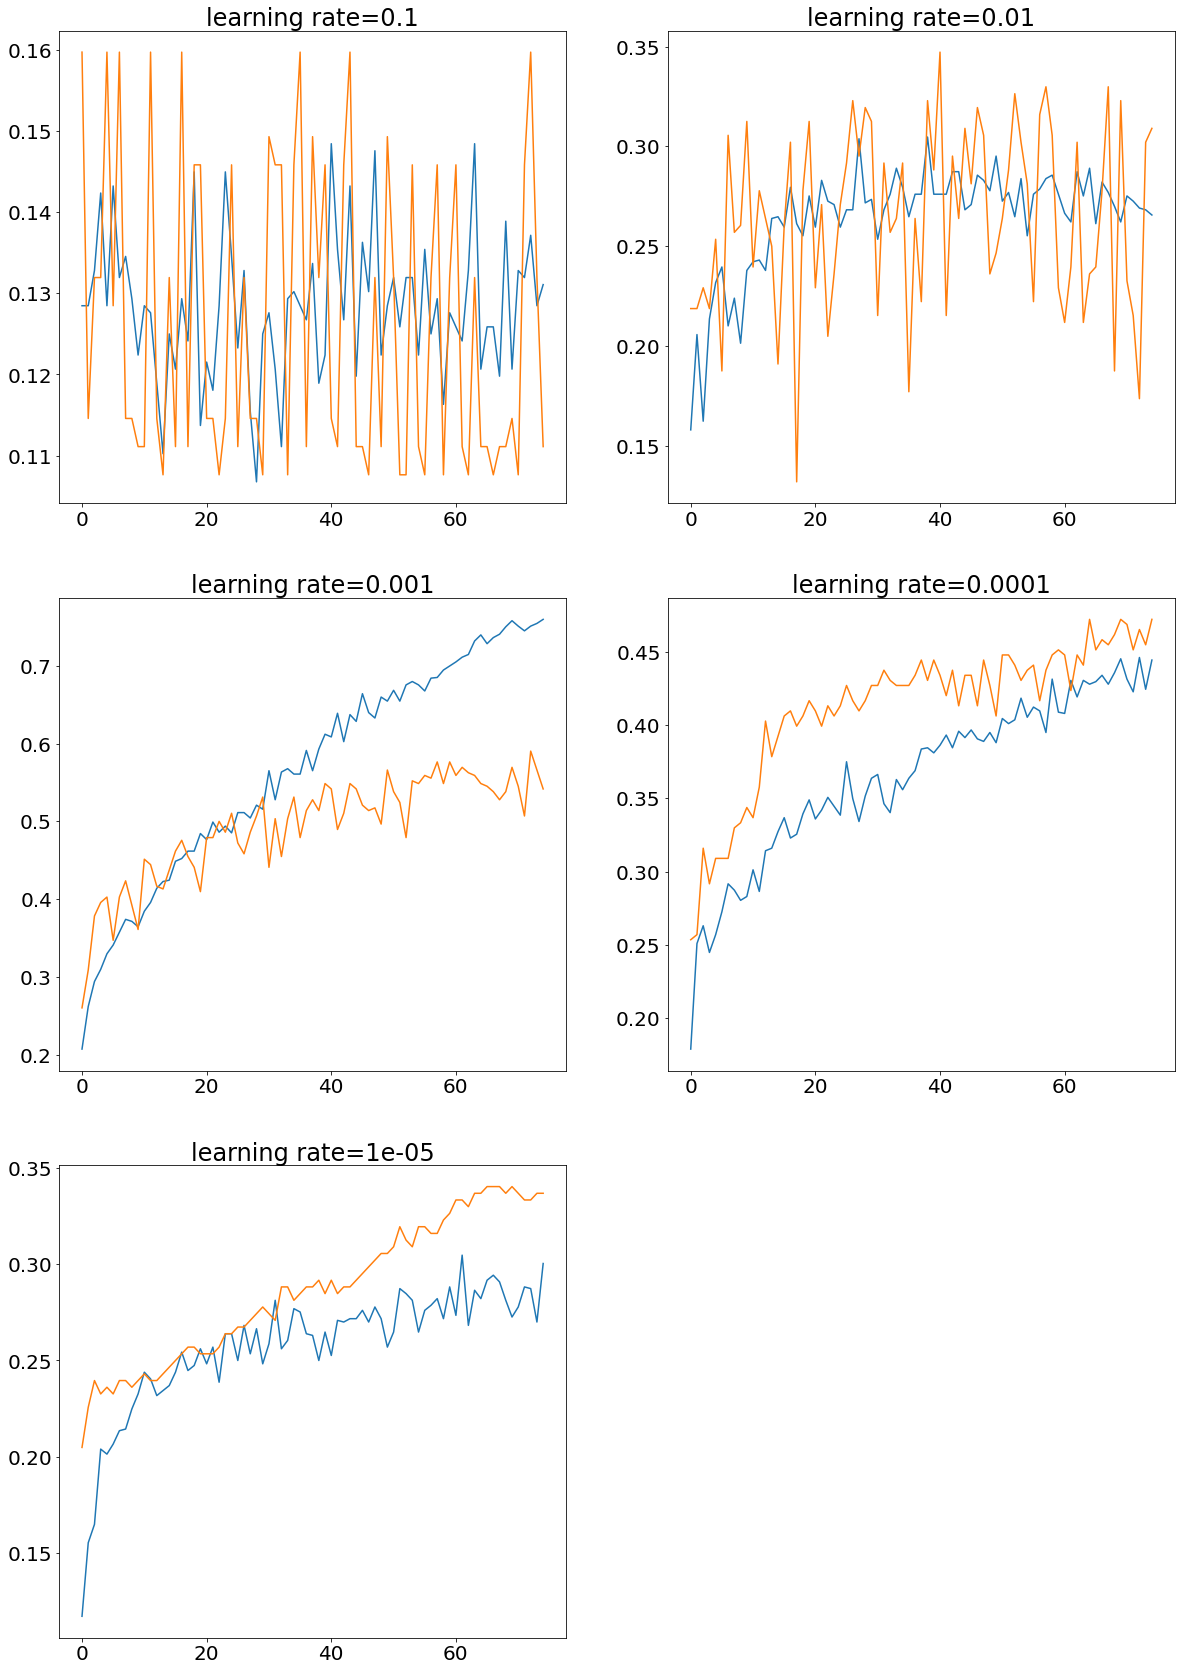

In [23]:
# Trying out different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
rcParams['figure.figsize'] = 20, 40
rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('rmsprop_lr.png', bbox_inches="tight")
pyplot.show()

# Adam Optimizer

In [24]:
# reset model
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_87 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 2, 128)          

In [25]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, lrate):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Adam(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    # fit model
    history = model.fit(X_train, y_train, epochs=75, batch_size=30, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose = 0)
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('learning rate='+str(lrate), pad=-50)

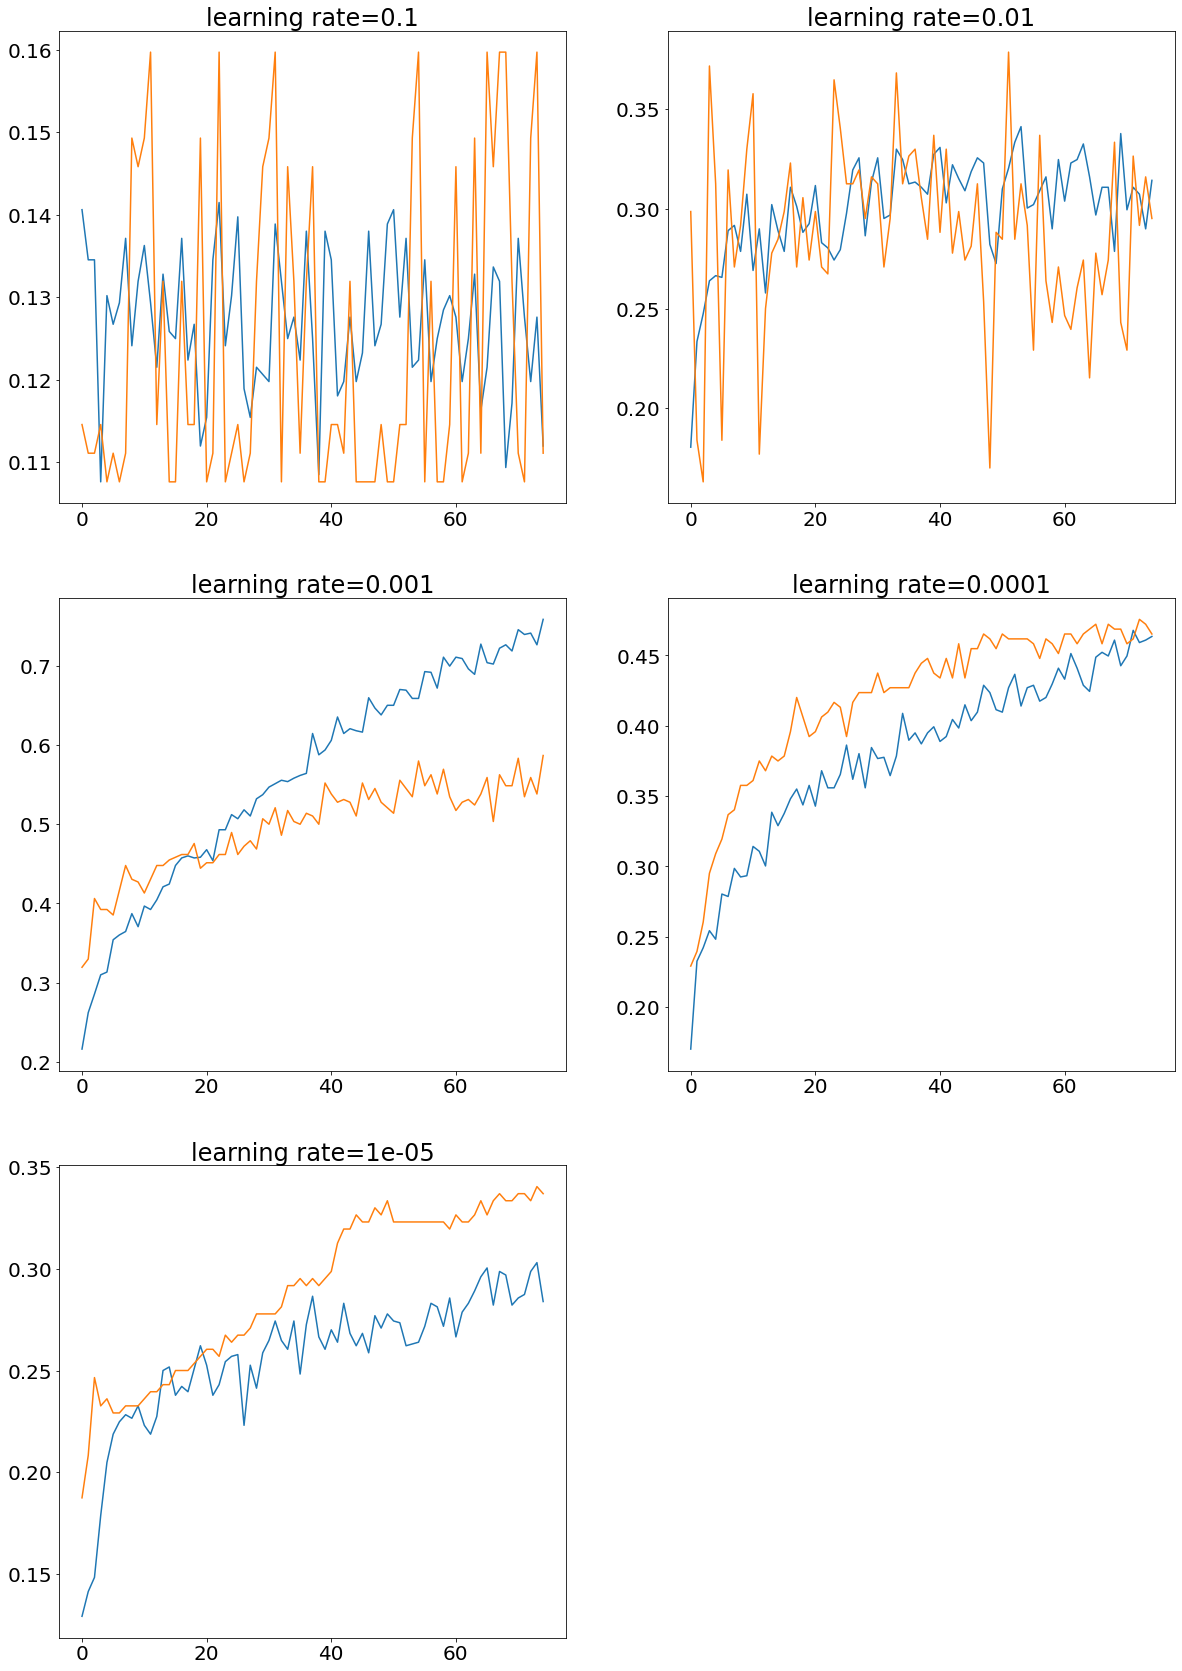

In [26]:
# Trying out different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
rcParams['figure.figsize'] = 20, 40
rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('adam_lr.png', bbox_inches="tight")
pyplot.show()

# Nadam Optimizer

In [45]:
# reset model
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.Nadam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_147 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_147 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_148 (Dropout)        (None, 2, 128)          

In [46]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, lrate):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    # fit model
    history = model.fit(X_train, y_train, epochs=75, batch_size=30, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose = 0)
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('learning rate='+str(lrate), pad=-50)

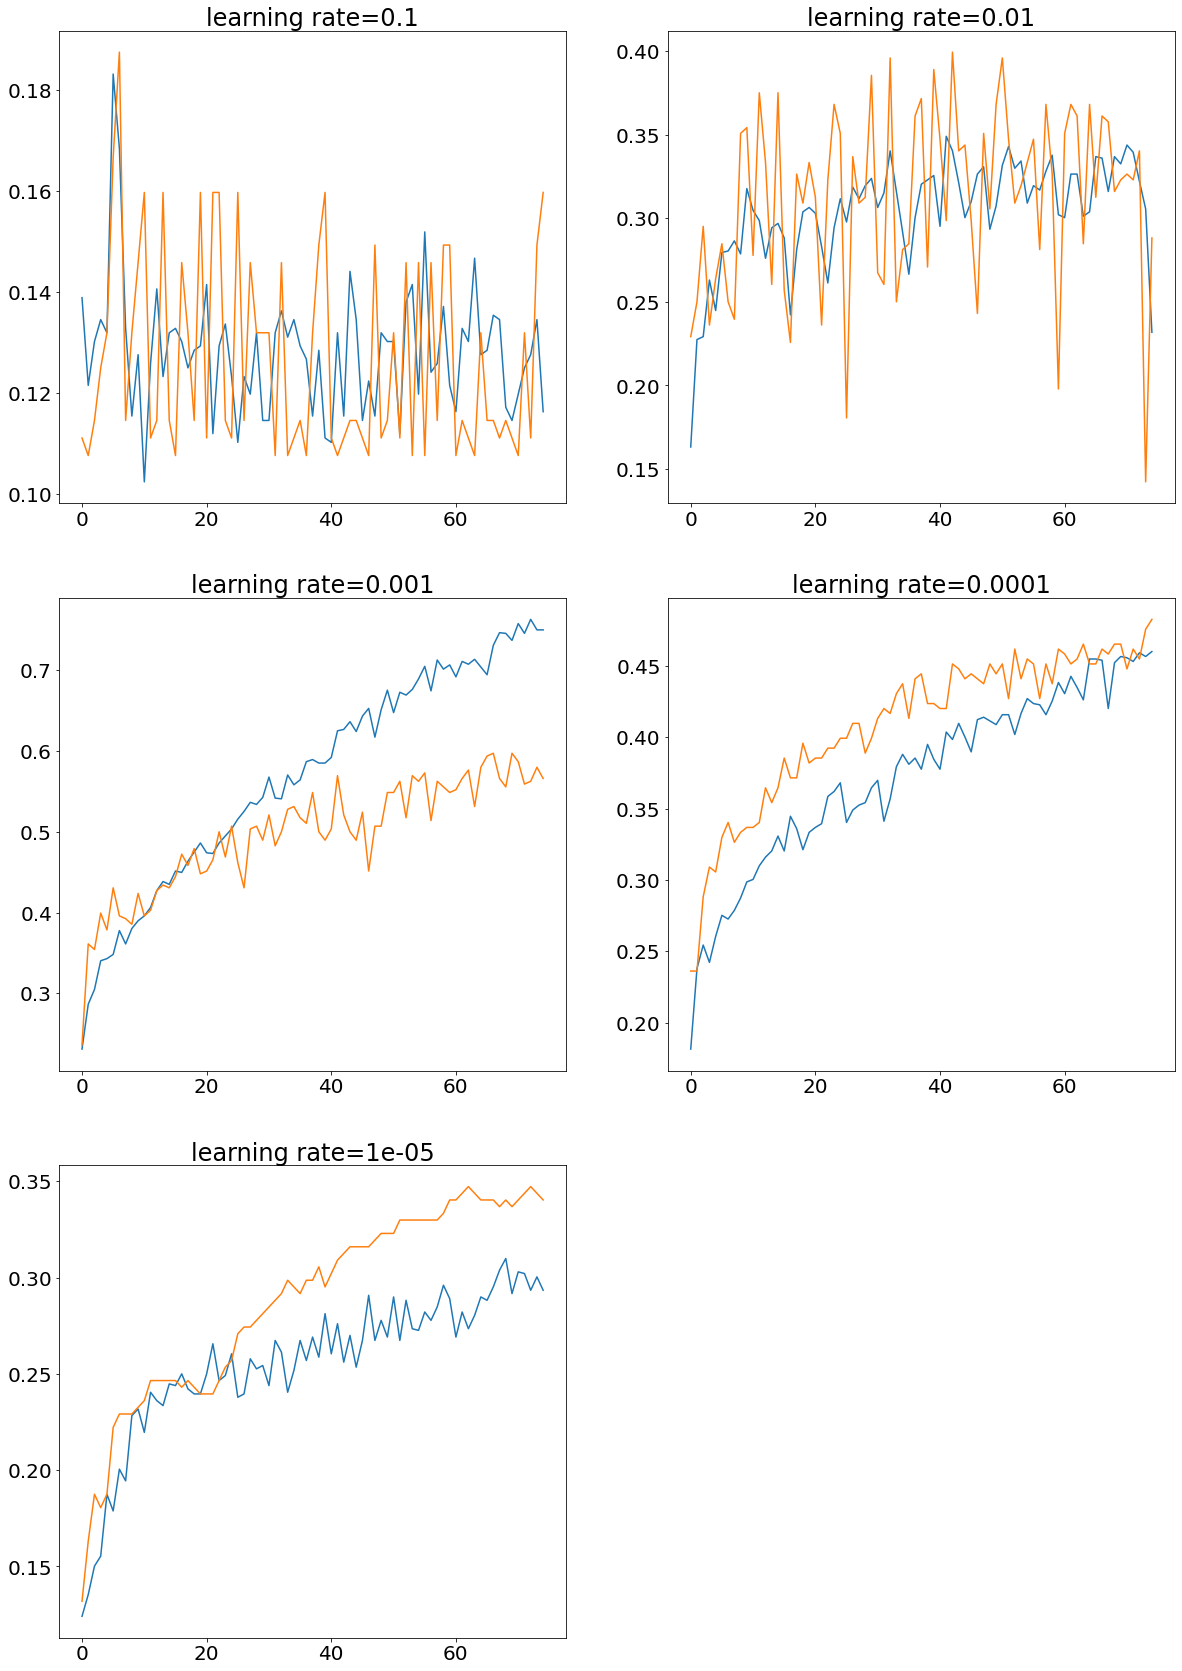

In [47]:
# Trying out different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
rcParams['figure.figsize'] = 20, 40
rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('nadam_lr.png', bbox_inches="tight")
pyplot.show()

# SGD Optimizer

In [42]:
# reset model
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_129 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_130 (Dropout)        (None, 2, 128)          

In [43]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, lrate):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.SGD(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    # fit model
    history = model.fit(X_train, y_train, epochs=75, batch_size=30, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose = 0)
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('learning rate='+str(lrate), pad=-50)

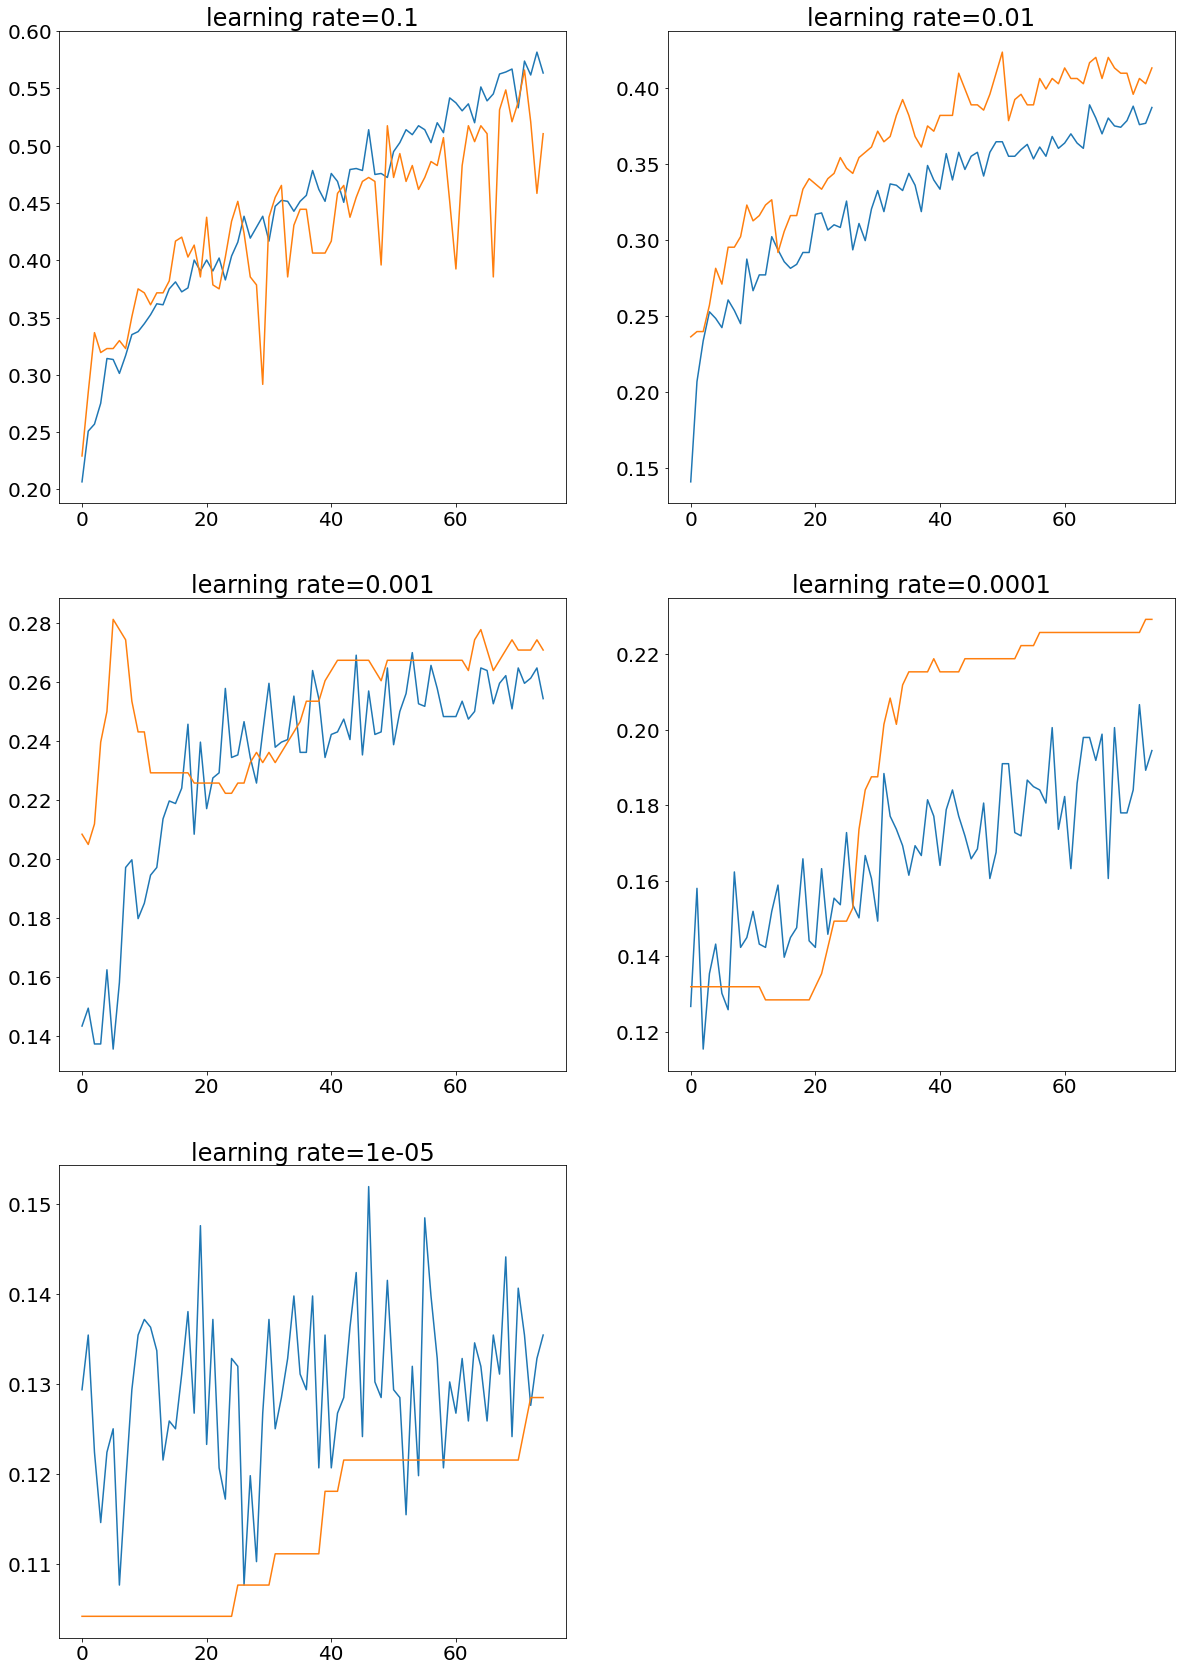

In [44]:
# Trying out different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
rcParams['figure.figsize'] = 20, 40
rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('sgd_lr.png', bbox_inches="tight")
pyplot.show()

In [61]:
# as the learning rate for SGD shows the best results for 0.01 and 0.001 the model will be ran again
# but this time the learning rate will decay as soon as there is no improvement in loss, starting with an intial rate of 0.01;
# SGD needs more epochs as well therefore we will try 200 epochs

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

In [62]:
# set up model
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_177 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_178 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_177 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
dropout_178 (Dropout)        (None, 2, 128)          

In [63]:
# fit model

model_history=model.fit(X_train, y_train,batch_size=30, epochs=200, validation_data=(X_test, y_test),callbacks=[rlrop, checkpoint])

Train on 1152 samples, validate on 288 samples
Epoch 1/200
1140/1152 [============================>.] - ETA: 0s - loss: 2.9012 - accuracy: 0.1553 ETA: 0s - loss: 2.9076 - accuracy
Epoch 00001: val_accuracy improved from -inf to 0.23264, saving model to best_model.hdf5
1152/1152 [==============================] - 2s 1ms/sample - loss: 2.9018 - accuracy: 0.1554 - val_loss: 2.8597 - val_accuracy: 0.2326
Epoch 2/200
1110/1152 [===========================>..] - ETA: 0s - loss: 2.8288 - accuracy: 0.1982
Epoch 00002: val_accuracy improved from 0.23264 to 0.24306, saving model to best_model.hdf5
1152/1152 [==============================] - 1s 905us/sample - loss: 2.8286 - accuracy: 0.1988 - val_loss: 2.7810 - val_accuracy: 0.2431
Epoch 3/200
1080/1152 [===========================>..] - ETA: 0s - loss: 2.7589 - accuracy: 0.2463
Epoch 00003: val_accuracy improved from 0.24306 to 0.27083, saving model to best_model.hdf5
1152/1152 [==============================] - 1s 893us/sample - loss: 2.7579 -

Epoch 55/200
1110/1152 [===========================>..] - ETA: 0s - loss: 2.0111 - accuracy: 0.3676
Epoch 00055: val_accuracy did not improve from 0.40972
1152/1152 [==============================] - 1s 856us/sample - loss: 1.9994 - accuracy: 0.3724 - val_loss: 1.9536 - val_accuracy: 0.4062
Epoch 56/200
1080/1152 [===========================>..] - ETA: 0s - loss: 1.9753 - accuracy: 0.3611
Epoch 00056: val_accuracy did not improve from 0.40972
1152/1152 [==============================] - 1s 857us/sample - loss: 1.9759 - accuracy: 0.3637 - val_loss: 1.9744 - val_accuracy: 0.4028
Epoch 57/200
1080/1152 [===========================>..] - ETA: 0s - loss: 1.9872 - accuracy: 0.3593
Epoch 00057: val_accuracy did not improve from 0.40972
1152/1152 [==============================] - 1s 865us/sample - loss: 1.9902 - accuracy: 0.3602 - val_loss: 1.9724 - val_accuracy: 0.3889
Epoch 58/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.9752 - accuracy: 0.3712
Epoch 00058: val_accurac

Epoch 83/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.8111 - accuracy: 0.4000
Epoch 00083: val_accuracy did not improve from 0.44097
1152/1152 [==============================] - 1s 855us/sample - loss: 1.8056 - accuracy: 0.4019 - val_loss: 1.7922 - val_accuracy: 0.4340
Epoch 84/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.8102 - accuracy: 0.3829
Epoch 00084: val_accuracy did not improve from 0.44097
1152/1152 [==============================] - 1s 857us/sample - loss: 1.8061 - accuracy: 0.3828 - val_loss: 1.8012 - val_accuracy: 0.4271
Epoch 85/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.7925 - accuracy: 0.4081
Epoch 00085: val_accuracy did not improve from 0.44097
1152/1152 [==============================] - 1s 864us/sample - loss: 1.7869 - accuracy: 0.4123 - val_loss: 1.7700 - val_accuracy: 0.4375
Epoch 86/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.8007 - accuracy: 0.3955
Epoch 00086: val_accurac

1080/1152 [===========================>..] - ETA: 0s - loss: 1.5566 - accuracy: 0.4528
Epoch 00138: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 885us/sample - loss: 1.5544 - accuracy: 0.4601 - val_loss: 1.5578 - val_accuracy: 0.4444
Epoch 139/200
1140/1152 [============================>.] - ETA: 0s - loss: 1.5582 - accuracy: 0.4623
Epoch 00139: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 887us/sample - loss: 1.5564 - accuracy: 0.4618 - val_loss: 1.5262 - val_accuracy: 0.4549
Epoch 140/200
1140/1152 [============================>.] - ETA: 0s - loss: 1.5452 - accuracy: 0.4526
Epoch 00140: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 893us/sample - loss: 1.5444 - accuracy: 0.4523 - val_loss: 1.5394 - val_accuracy: 0.4514
Epoch 141/200
1140/1152 [============================>.] - ETA: 0s - loss: 1.5544 - accuracy: 0.4456
Epoch 00141: val_accuracy did not 

1110/1152 [===========================>..] - ETA: 0s - loss: 1.4574 - accuracy: 0.4775
Epoch 00166: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 883us/sample - loss: 1.4609 - accuracy: 0.4792 - val_loss: 1.4566 - val_accuracy: 0.4583
Epoch 167/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.4691 - accuracy: 0.4829
Epoch 00167: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 883us/sample - loss: 1.4662 - accuracy: 0.4826 - val_loss: 1.4660 - val_accuracy: 0.4514
Epoch 168/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.4305 - accuracy: 0.4784
Epoch 00168: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 885us/sample - loss: 1.4303 - accuracy: 0.4792 - val_loss: 1.4723 - val_accuracy: 0.4514
Epoch 169/200
1080/1152 [===========================>..] - ETA: 0s - loss: 1.4524 - accuracy: 0.4787
Epoch 00169: val_accuracy did not 

1110/1152 [===========================>..] - ETA: 0s - loss: 1.3770 - accuracy: 0.5072
Epoch 00194: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 888us/sample - loss: 1.3737 - accuracy: 0.5087 - val_loss: 1.3965 - val_accuracy: 0.4618
Epoch 195/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.3784 - accuracy: 0.5036
Epoch 00195: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 885us/sample - loss: 1.3720 - accuracy: 0.5061 - val_loss: 1.4009 - val_accuracy: 0.4583
Epoch 196/200
1110/1152 [===========================>..] - ETA: 0s - loss: 1.3724 - accuracy: 0.5036
Epoch 00196: val_accuracy did not improve from 0.47222
1152/1152 [==============================] - 1s 885us/sample - loss: 1.3682 - accuracy: 0.5069 - val_loss: 1.3944 - val_accuracy: 0.4688
Epoch 197/200
1080/1152 [===========================>..] - ETA: 0s - loss: 1.3527 - accuracy: 0.5065
Epoch 00197: val_accuracy did not 

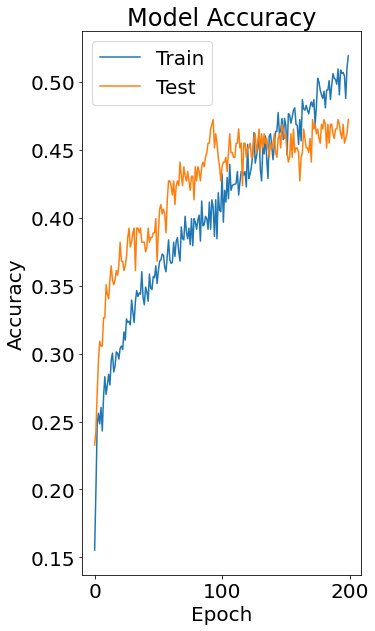

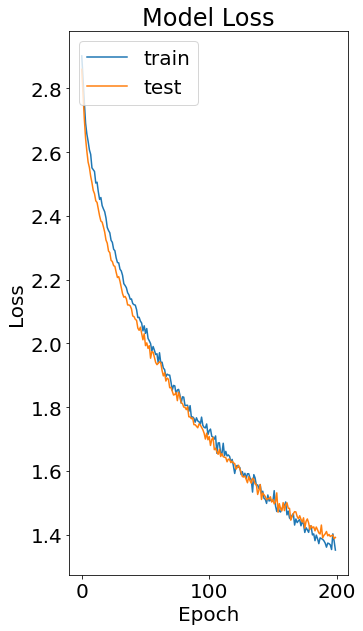

In [64]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
rcParams['figure.figsize'] = 5, 10
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [65]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,sad,calm
2,angry,angry
3,disgust,disgust
4,calm,neutral
5,calm,neutral
6,calm,calm
7,disgust,disgust
8,disgust,disgust
9,sad,neutral


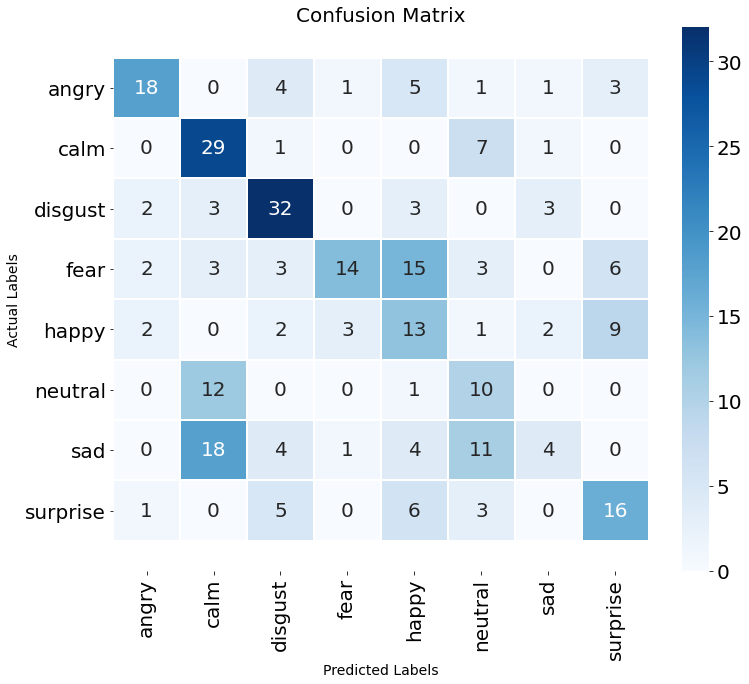

In [66]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

# Finding ideal Batch Size and Number of Epochs through cross validation

In [8]:
y_trainHot=np.argmax(y_train, axis=1)

In [22]:
def make_classifier():
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model

In [23]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, verbose=1)

batch_size = [30,35,40]
epochs = [30,45,60]
params = dict(batch_size=batch_size, epochs=epochs)


grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6545 - accuracy: 0.2109
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.2365 - accuracy: 0.2708
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0520 - accuracy: 0.2799
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9393 - accuracy: 0.3099
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8582 - accuracy: 0.3255
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8122 - accuracy: 0.3320
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7630 - accuracy: 0.3607
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7401 - accuracy: 0.3424
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7347 - accuracy: 0.3594
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6186 - accuracy: 0.2005
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.2431 - accuracy: 0.2604
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0126 - accuracy: 0.2786
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9145 - accuracy: 0.2852
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8338 - accuracy: 0.3255
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7796 - accuracy: 0.3464
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7263 - accuracy: 0.3607
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.6983 - accuracy: 0.3633
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.6659 - accuracy: 0.3620
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 2ms/sample - loss: 2.6330 - accuracy: 0.2031
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.2092 - accuracy: 0.2422
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0308 - accuracy: 0.2799
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8874 - accuracy: 0.2969
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8632 - accuracy: 0.3047
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8019 - accuracy: 0.3060
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7390 - accuracy: 0.3281
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7246 - accuracy: 0.3346
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7142 - accuracy: 0.3398
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6312 - accuracy: 0.2331
Epoch 2/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.2226 - accuracy: 0.2734
Epoch 3/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.0590 - accuracy: 0.2773
Epoch 4/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.9086 - accuracy: 0.2917
Epoch 5/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8606 - accuracy: 0.3021
Epoch 6/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7569 - accuracy: 0.3490
Epoch 7/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7290 - accuracy: 0.3477
Epoch 8/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7266 - accuracy: 0.3633
Epoch 9/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.6872 - accuracy: 0.3646
Epoch 10/45
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 2ms/sample - loss: 2.6224 - accuracy: 0.2109
Epoch 2/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.2262 - accuracy: 0.2682
Epoch 3/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.0303 - accuracy: 0.2773
Epoch 4/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8913 - accuracy: 0.3060
Epoch 5/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8203 - accuracy: 0.3229
Epoch 6/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7509 - accuracy: 0.3424
Epoch 7/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7468 - accuracy: 0.3529
Epoch 8/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7121 - accuracy: 0.3659
Epoch 9/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.6593 - accuracy: 0.3802
Epoch 10/45
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6527 - accuracy: 0.2201
Epoch 2/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.2615 - accuracy: 0.2513
Epoch 3/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.0831 - accuracy: 0.2409
Epoch 4/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.9320 - accuracy: 0.2878
Epoch 5/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8618 - accuracy: 0.3086
Epoch 6/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8138 - accuracy: 0.3047
Epoch 7/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7472 - accuracy: 0.3242
Epoch 8/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7354 - accuracy: 0.3151
Epoch 9/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7073 - accuracy: 0.3477
Epoch 10/45
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6475 - accuracy: 0.2083
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2350 - accuracy: 0.2630
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0462 - accuracy: 0.2812
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9392 - accuracy: 0.2969
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8393 - accuracy: 0.3307
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8091 - accuracy: 0.3307
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7467 - accuracy: 0.3516
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7145 - accuracy: 0.3581
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7036 - accuracy: 0.3737
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6513 - accuracy: 0.2096
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2370 - accuracy: 0.2539
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0565 - accuracy: 0.2812
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9276 - accuracy: 0.2943
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8324 - accuracy: 0.3333
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7798 - accuracy: 0.3424
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7385 - accuracy: 0.3555
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7057 - accuracy: 0.3542
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.6669 - accuracy: 0.3607
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6411 - accuracy: 0.2057
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2678 - accuracy: 0.2331
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0359 - accuracy: 0.2760
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9226 - accuracy: 0.2852
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8572 - accuracy: 0.2786
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7964 - accuracy: 0.3164
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7659 - accuracy: 0.3177
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7369 - accuracy: 0.3255
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7130 - accuracy: 0.3190
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6525 - accuracy: 0.2201
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.2731 - accuracy: 0.2591
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0667 - accuracy: 0.2878
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9476 - accuracy: 0.3099
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8649 - accuracy: 0.3008
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8019 - accuracy: 0.3372
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7740 - accuracy: 0.3333
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7384 - accuracy: 0.3620
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7246 - accuracy: 0.3438
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 3s 4ms/sample - loss: 2.6560 - accuracy: 0.2174
Epoch 2/30
768/768 [==============================] - 1s 2ms/sample - loss: 2.2553 - accuracy: 0.27210s - loss: 2
Epoch 3/30
768/768 [==============================] - 1s 2ms/sample - loss: 2.0502 - accuracy: 0.2969
Epoch 4/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.9396 - accuracy: 0.3138
Epoch 5/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.8311 - accuracy: 0.3372
Epoch 6/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7956 - accuracy: 0.3190
Epoch 7/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7460 - accuracy: 0.3424
Epoch 8/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7008 - accuracy: 0.3672
Epoch 9/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.6791 - accuracy: 0.3737
Epoch 10/30
768/768 [============================

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6677 - accuracy: 0.1940
Epoch 2/30
768/768 [==============================] - 1s 2ms/sample - loss: 2.2934 - accuracy: 0.2005
Epoch 3/30
768/768 [==============================] - 1s 2ms/sample - loss: 2.0793 - accuracy: 0.2487
Epoch 4/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.9406 - accuracy: 0.3099
Epoch 5/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.8790 - accuracy: 0.2969
Epoch 6/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.8074 - accuracy: 0.3021
Epoch 7/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7945 - accuracy: 0.3411
Epoch 8/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7350 - accuracy: 0.3424
Epoch 9/30
768/768 [==============================] - 1s 2ms/sample - loss: 1.7189 - accuracy: 0.3255
Epoch 10/30
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6671 - accuracy: 0.2083
Epoch 2/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.2948 - accuracy: 0.2474
Epoch 3/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.0868 - accuracy: 0.2643
Epoch 4/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.9413 - accuracy: 0.2943
Epoch 5/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8825 - accuracy: 0.3125
Epoch 6/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8333 - accuracy: 0.2995
Epoch 7/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7837 - accuracy: 0.3281
Epoch 8/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7250 - accuracy: 0.3451
Epoch 9/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7157 - accuracy: 0.3451
Epoch 10/45
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6626 - accuracy: 0.2279
Epoch 2/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.2709 - accuracy: 0.2682
Epoch 3/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.0751 - accuracy: 0.2969
Epoch 4/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.9552 - accuracy: 0.3086
Epoch 5/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8519 - accuracy: 0.3268
Epoch 6/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7982 - accuracy: 0.3307
Epoch 7/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7384 - accuracy: 0.3529
Epoch 8/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7313 - accuracy: 0.3464
Epoch 9/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.6913 - accuracy: 0.3555
Epoch 10/45
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6567 - accuracy: 0.2305
Epoch 2/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.2857 - accuracy: 0.2604
Epoch 3/45
768/768 [==============================] - 1s 1ms/sample - loss: 2.0695 - accuracy: 0.2552
Epoch 4/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.9463 - accuracy: 0.2852
Epoch 5/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8534 - accuracy: 0.2956
Epoch 6/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.8032 - accuracy: 0.3112
Epoch 7/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7551 - accuracy: 0.3242
Epoch 8/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.7424 - accuracy: 0.3203
Epoch 9/45
768/768 [==============================] - 1s 1ms/sample - loss: 1.6896 - accuracy: 0.3464
Epoch 10/45
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 3s 4ms/sample - loss: 2.6727 - accuracy: 0.2344
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2992 - accuracy: 0.2461
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0983 - accuracy: 0.2799
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9805 - accuracy: 0.3060
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8922 - accuracy: 0.3073
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8219 - accuracy: 0.3385
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7630 - accuracy: 0.3542
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7441 - accuracy: 0.3372
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7241 - accuracy: 0.36070s - loss: 1.7339 - accuracy
Epoch 10/60
768/768 [============

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6755 - accuracy: 0.2266
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2851 - accuracy: 0.2526
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0773 - accuracy: 0.2734
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9382 - accuracy: 0.3060
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8685 - accuracy: 0.3151
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7899 - accuracy: 0.3477
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7485 - accuracy: 0.3542
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7087 - accuracy: 0.3685
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.6796 - accuracy: 0.3646
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6669 - accuracy: 0.2044
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2882 - accuracy: 0.2292
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0713 - accuracy: 0.2734
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9706 - accuracy: 0.2852
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8810 - accuracy: 0.2852
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8131 - accuracy: 0.2995
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7710 - accuracy: 0.3333
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7619 - accuracy: 0.3307
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7037 - accuracy: 0.3385
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6916 - accuracy: 0.2018
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.3111 - accuracy: 0.2539
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0900 - accuracy: 0.2630
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9745 - accuracy: 0.2826
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8961 - accuracy: 0.3190
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8404 - accuracy: 0.3190
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7955 - accuracy: 0.3320
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7615 - accuracy: 0.3359
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7378 - accuracy: 0.3438
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.6725 - accuracy: 0.1953
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.3102 - accuracy: 0.2656
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.1089 - accuracy: 0.2682
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9630 - accuracy: 0.3021
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8736 - accuracy: 0.3112
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7933 - accuracy: 0.3385
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7514 - accuracy: 0.3424
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7350 - accuracy: 0.3503
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.6829 - accuracy: 0.3711
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/30
768/768 [==============================] - 2s 3ms/sample - loss: 2.7161 - accuracy: 0.1914
Epoch 2/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.3458 - accuracy: 0.2500
Epoch 3/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.1426 - accuracy: 0.2565
Epoch 4/30
768/768 [==============================] - 1s 1ms/sample - loss: 2.0026 - accuracy: 0.2917
Epoch 5/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.9097 - accuracy: 0.2852
Epoch 6/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8542 - accuracy: 0.3125
Epoch 7/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.8052 - accuracy: 0.3190
Epoch 8/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7752 - accuracy: 0.3190
Epoch 9/30
768/768 [==============================] - 1s 1ms/sample - loss: 1.7541 - accuracy: 0.3268
Epoch 10/30
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 3s 4ms/sample - loss: 2.6764 - accuracy: 0.2266
Epoch 2/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.3237 - accuracy: 0.2513
Epoch 3/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.1194 - accuracy: 0.2708
Epoch 4/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.9616 - accuracy: 0.3138
Epoch 5/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8696 - accuracy: 0.3190
Epoch 6/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8574 - accuracy: 0.2956
Epoch 7/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7725 - accuracy: 0.3346
Epoch 8/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7827 - accuracy: 0.3229
Epoch 9/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7360 - accuracy: 0.3477
Epoch 10/45
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6900 - accuracy: 0.2057
Epoch 2/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.2906 - accuracy: 0.2591
Epoch 3/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.0914 - accuracy: 0.3021
Epoch 4/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.9522 - accuracy: 0.3021
Epoch 5/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8984 - accuracy: 0.3138
Epoch 6/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8077 - accuracy: 0.3268
Epoch 7/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7745 - accuracy: 0.3503
Epoch 8/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7291 - accuracy: 0.3464
Epoch 9/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.6945 - accuracy: 0.3542
Epoch 10/45
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/45
768/768 [==============================] - 2s 3ms/sample - loss: 2.6708 - accuracy: 0.2018
Epoch 2/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.2870 - accuracy: 0.2669
Epoch 3/45
768/768 [==============================] - 1s 2ms/sample - loss: 2.1140 - accuracy: 0.2253
Epoch 4/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.9548 - accuracy: 0.2721
Epoch 5/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8787 - accuracy: 0.2865
Epoch 6/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.8503 - accuracy: 0.2865
Epoch 7/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7881 - accuracy: 0.3125
Epoch 8/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7585 - accuracy: 0.3125
Epoch 9/45
768/768 [==============================] - 1s 2ms/sample - loss: 1.7364 - accuracy: 0.3424
Epoch 10/45
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6896 - accuracy: 0.2018
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.3195 - accuracy: 0.2617
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.1190 - accuracy: 0.2747
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9805 - accuracy: 0.2917
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8825 - accuracy: 0.3516
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8094 - accuracy: 0.3411
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7834 - accuracy: 0.3268
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7563 - accuracy: 0.3411
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7254 - accuracy: 0.3685
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6911 - accuracy: 0.2057
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2975 - accuracy: 0.2826
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.1084 - accuracy: 0.2956
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9920 - accuracy: 0.2799
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8768 - accuracy: 0.3125
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8341 - accuracy: 0.3333
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7665 - accuracy: 0.3490
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7364 - accuracy: 0.3503
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7066 - accuracy: 0.3594
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6929 - accuracy: 0.1862
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.3420 - accuracy: 0.2318
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.1273 - accuracy: 0.2721
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0011 - accuracy: 0.2826
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8846 - accuracy: 0.3034
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8642 - accuracy: 0.2969
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7856 - accuracy: 0.3268
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7690 - accuracy: 0.3451
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7450 - accuracy: 0.3477
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 3s 3ms/sample - loss: 2.5586 - accuracy: 0.2188
Epoch 2/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.1245 - accuracy: 0.2648
Epoch 3/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.9418 - accuracy: 0.2960
Epoch 4/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.8259 - accuracy: 0.3168
Epoch 5/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.7460 - accuracy: 0.3446
Epoch 6/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.7287 - accuracy: 0.3403
Epoch 7/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6825 - accuracy: 0.3724
Epoch 8/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6511 - accuracy: 0.3689
Epoch 9/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6580 - accuracy: 0.3828
Epoch 10/60
1152/1152 [===================

In [24]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.508681 using {'batch_size': 35, 'epochs': 60}
0.461806 (0.026924) with: {'batch_size': 30, 'epochs': 30}
0.493924 (0.031346) with: {'batch_size': 30, 'epochs': 45}
0.493924 (0.021298) with: {'batch_size': 30, 'epochs': 60}
0.449653 (0.017187) with: {'batch_size': 35, 'epochs': 30}
0.458333 (0.046048) with: {'batch_size': 35, 'epochs': 45}
0.508681 (0.008593) with: {'batch_size': 35, 'epochs': 60}
0.413194 (0.035854) with: {'batch_size': 40, 'epochs': 30}
0.454861 (0.027340) with: {'batch_size': 40, 'epochs': 45}
0.460069 (0.022934) with: {'batch_size': 40, 'epochs': 60}


# Finding ideal optimizer through cross validation 

In [9]:
def make_classifier(optimizer='SGD'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

In [10]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

optimizer = ['SGD', 'RMSprop', 'Adam', 'Nadam']
params = dict(optimizer=optimizer)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.9328 - accuracy: 0.1354
Epoch 2/60
768/768 [==============================] - 1s 731us/sample - loss: 2.8822 - accuracy: 0.1797
Epoch 3/60
768/768 [==============================] - 1s 738us/sample - loss: 2.8547 - accuracy: 0.2161
Epoch 4/60
768/768 [==============================] - 1s 732us/sample - loss: 2.8156 - accuracy: 0.2357
Epoch 5/60
768/768 [==============================] - 1s 743us/sample - loss: 2.7716 - accuracy: 0.2344
Epoch 6/60
768/768 [==============================] - 1s 742us/sample - loss: 2.7240 - accuracy: 0.2708
Epoch 7/60
768/768 [==============================] - 1s 730us/sample - loss: 2.7068 - accuracy: 0.2539
Epoch 8/60
768/768 [==============================] - 1s 735us/sample - loss: 2.6628 - accuracy: 0.2526
Epoch 9/60
768/768 [==============================] - 1s 729us/sample - loss: 2.6702 - accuracy: 0.2357
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.9390 - accuracy: 0.1484
Epoch 2/60
768/768 [==============================] - 1s 742us/sample - loss: 2.8889 - accuracy: 0.1510
Epoch 3/60
768/768 [==============================] - 1s 747us/sample - loss: 2.8552 - accuracy: 0.1836
Epoch 4/60
768/768 [==============================] - 1s 756us/sample - loss: 2.8104 - accuracy: 0.2148
Epoch 5/60
768/768 [==============================] - 1s 753us/sample - loss: 2.7677 - accuracy: 0.2148
Epoch 6/60
768/768 [==============================] - 1s 745us/sample - loss: 2.7389 - accuracy: 0.2292
Epoch 7/60
768/768 [==============================] - 1s 744us/sample - loss: 2.6900 - accuracy: 0.2461
Epoch 8/60
768/768 [==============================] - 1s 740us/sample - loss: 2.6682 - accuracy: 0.2578
Epoch 9/60
768/768 [==============================] - 1s 749us/sample - loss: 2.6305 - accuracy: 0.2695
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.9421 - accuracy: 0.1458
Epoch 2/60
768/768 [==============================] - 1s 734us/sample - loss: 2.8952 - accuracy: 0.1862
Epoch 3/60
768/768 [==============================] - 1s 740us/sample - loss: 2.8471 - accuracy: 0.2240
Epoch 4/60
768/768 [==============================] - 1s 735us/sample - loss: 2.8143 - accuracy: 0.2227
Epoch 5/60
768/768 [==============================] - 1s 751us/sample - loss: 2.7693 - accuracy: 0.2161
Epoch 6/60
768/768 [==============================] - 1s 748us/sample - loss: 2.7097 - accuracy: 0.2448
Epoch 7/60
768/768 [==============================] - 1s 748us/sample - loss: 2.7082 - accuracy: 0.2253
Epoch 8/60
768/768 [==============================] - 1s 751us/sample - loss: 2.6654 - accuracy: 0.2461
Epoch 9/60
768/768 [==============================] - 1s 732us/sample - loss: 2.6697 - accuracy: 0.2435
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.5488 - accuracy: 0.2383
Epoch 2/60
768/768 [==============================] - 1s 752us/sample - loss: 2.1271 - accuracy: 0.2786
Epoch 3/60
768/768 [==============================] - 1s 761us/sample - loss: 1.9951 - accuracy: 0.2773
Epoch 4/60
768/768 [==============================] - 1s 754us/sample - loss: 1.8901 - accuracy: 0.2891
Epoch 5/60
768/768 [==============================] - 1s 749us/sample - loss: 1.8495 - accuracy: 0.2891
Epoch 6/60
768/768 [==============================] - 1s 749us/sample - loss: 1.8056 - accuracy: 0.3138
Epoch 7/60
768/768 [==============================] - 1s 764us/sample - loss: 1.7625 - accuracy: 0.3242
Epoch 8/60
768/768 [==============================] - 1s 754us/sample - loss: 1.7328 - accuracy: 0.3542
Epoch 9/60
768/768 [==============================] - 1s 747us/sample - loss: 1.7246 - accuracy: 0.3646
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.5374 - accuracy: 0.2305
Epoch 2/60
768/768 [==============================] - 1s 801us/sample - loss: 2.1497 - accuracy: 0.2318
Epoch 3/60
768/768 [==============================] - 1s 780us/sample - loss: 1.9562 - accuracy: 0.2956
Epoch 4/60
768/768 [==============================] - 1s 762us/sample - loss: 1.8520 - accuracy: 0.3320
Epoch 5/60
768/768 [==============================] - 1s 751us/sample - loss: 1.8385 - accuracy: 0.2995
Epoch 6/60
768/768 [==============================] - 1s 744us/sample - loss: 1.7565 - accuracy: 0.3359
Epoch 7/60
768/768 [==============================] - 1s 784us/sample - loss: 1.7449 - accuracy: 0.3307
Epoch 8/60
768/768 [==============================] - 1s 765us/sample - loss: 1.6785 - accuracy: 0.3789
Epoch 9/60
768/768 [==============================] - 1s 753us/sample - loss: 1.6849 - accuracy: 0.3711
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5289 - accuracy: 0.2240
Epoch 2/60
768/768 [==============================] - 1s 931us/sample - loss: 2.1387 - accuracy: 0.2565
Epoch 3/60
768/768 [==============================] - 1s 892us/sample - loss: 1.9708 - accuracy: 0.2656
Epoch 4/60
768/768 [==============================] - 1s 837us/sample - loss: 1.8842 - accuracy: 0.2865
Epoch 5/60
768/768 [==============================] - 1s 842us/sample - loss: 1.8133 - accuracy: 0.2995
Epoch 6/60
768/768 [==============================] - 1s 870us/sample - loss: 1.8074 - accuracy: 0.2852
Epoch 7/60
768/768 [==============================] - 1s 817us/sample - loss: 1.7724 - accuracy: 0.3190
Epoch 8/60
768/768 [==============================] - 1s 792us/sample - loss: 1.7401 - accuracy: 0.3112
Epoch 9/60
768/768 [==============================] - 1s 792us/sample - loss: 1.7272 - accuracy: 0.3307
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.6347 - accuracy: 0.2135
Epoch 2/60
768/768 [==============================] - 1s 803us/sample - loss: 2.2320 - accuracy: 0.2708
Epoch 3/60
768/768 [==============================] - 1s 783us/sample - loss: 2.0091 - accuracy: 0.2930
Epoch 4/60
768/768 [==============================] - 1s 799us/sample - loss: 1.8873 - accuracy: 0.3229
Epoch 5/60
768/768 [==============================] - 1s 797us/sample - loss: 1.8367 - accuracy: 0.3112
Epoch 6/60
768/768 [==============================] - 1s 803us/sample - loss: 1.8037 - accuracy: 0.3385
Epoch 7/60
768/768 [==============================] - 1s 803us/sample - loss: 1.7610 - accuracy: 0.3464
Epoch 8/60
768/768 [==============================] - 1s 795us/sample - loss: 1.7615 - accuracy: 0.3346
Epoch 9/60
768/768 [==============================] - 1s 788us/sample - loss: 1.7036 - accuracy: 0.3698
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.6346 - accuracy: 0.1966
Epoch 2/60
768/768 [==============================] - 1s 786us/sample - loss: 2.2359 - accuracy: 0.2435
Epoch 3/60
768/768 [==============================] - 1s 791us/sample - loss: 1.9966 - accuracy: 0.3229
Epoch 4/60
768/768 [==============================] - 1s 791us/sample - loss: 1.9279 - accuracy: 0.2773
Epoch 5/60
768/768 [==============================] - 1s 793us/sample - loss: 1.8293 - accuracy: 0.3255
Epoch 6/60
768/768 [==============================] - 1s 780us/sample - loss: 1.7807 - accuracy: 0.3268
Epoch 7/60
768/768 [==============================] - 1s 793us/sample - loss: 1.7569 - accuracy: 0.3372
Epoch 8/60
768/768 [==============================] - 1s 784us/sample - loss: 1.7154 - accuracy: 0.3451
Epoch 9/60
768/768 [==============================] - 1s 781us/sample - loss: 1.6592 - accuracy: 0.3659
Epoch 10/60
768/768 [========================

384/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.6304 - accuracy: 0.2253
Epoch 2/60
768/768 [==============================] - 1s 790us/sample - loss: 2.2410 - accuracy: 0.2279
Epoch 3/60
768/768 [==============================] - 1s 783us/sample - loss: 2.0507 - accuracy: 0.2448
Epoch 4/60
768/768 [==============================] - 1s 782us/sample - loss: 1.9434 - accuracy: 0.2760
Epoch 5/60
768/768 [==============================] - 1s 793us/sample - loss: 1.8401 - accuracy: 0.2826
Epoch 6/60
768/768 [==============================] - 1s 787us/sample - loss: 1.8155 - accuracy: 0.2982
Epoch 7/60
768/768 [==============================] - 1s 782us/sample - loss: 1.7570 - accuracy: 0.3203
Epoch 8/60
768/768 [==============================] - 1s 778us/sample - loss: 1.7222 - accuracy: 0.3216
Epoch 9/60
768/768 [==============================] - 1s 782us/sample - loss: 1.7006 - accuracy: 0.3424
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6763 - accuracy: 0.2122
Epoch 2/60
768/768 [==============================] - 1s 813us/sample - loss: 2.3067 - accuracy: 0.2695
Epoch 3/60
768/768 [==============================] - 1s 803us/sample - loss: 2.0958 - accuracy: 0.2943
Epoch 4/60
768/768 [==============================] - 1s 814us/sample - loss: 1.9713 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 797us/sample - loss: 1.8631 - accuracy: 0.3346
Epoch 6/60
768/768 [==============================] - 1s 808us/sample - loss: 1.8097 - accuracy: 0.3333
Epoch 7/60
768/768 [==============================] - 1s 796us/sample - loss: 1.7764 - accuracy: 0.3385
Epoch 8/60
768/768 [==============================] - 1s 803us/sample - loss: 1.7521 - accuracy: 0.3464
Epoch 9/60
768/768 [==============================] - 1s 804us/sample - loss: 1.7068 - accuracy: 0.3568
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6441 - accuracy: 0.2031
Epoch 2/60
768/768 [==============================] - 1s 807us/sample - loss: 2.2790 - accuracy: 0.2630
Epoch 3/60
768/768 [==============================] - 1s 802us/sample - loss: 2.0491 - accuracy: 0.3086
Epoch 4/60
768/768 [==============================] - 1s 805us/sample - loss: 1.9355 - accuracy: 0.2982
Epoch 5/60
768/768 [==============================] - 1s 806us/sample - loss: 1.8638 - accuracy: 0.3099
Epoch 6/60
768/768 [==============================] - 1s 804us/sample - loss: 1.8032 - accuracy: 0.3294
Epoch 7/60
768/768 [==============================] - 1s 812us/sample - loss: 1.7414 - accuracy: 0.3555
Epoch 8/60
768/768 [==============================] - 1s 808us/sample - loss: 1.7273 - accuracy: 0.3555
Epoch 9/60
768/768 [==============================] - 1s 808us/sample - loss: 1.6837 - accuracy: 0.3828
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6567 - accuracy: 0.2201
Epoch 2/60
768/768 [==============================] - 1s 835us/sample - loss: 2.2973 - accuracy: 0.2344
Epoch 3/60
768/768 [==============================] - 1s 801us/sample - loss: 2.0933 - accuracy: 0.2669
Epoch 4/60
768/768 [==============================] - 1s 809us/sample - loss: 1.9717 - accuracy: 0.2747
Epoch 5/60
768/768 [==============================] - 1s 807us/sample - loss: 1.8905 - accuracy: 0.2734
Epoch 6/60
768/768 [==============================] - 1s 801us/sample - loss: 1.8199 - accuracy: 0.3229
Epoch 7/60
768/768 [==============================] - 1s 801us/sample - loss: 1.7836 - accuracy: 0.3255
Epoch 8/60
768/768 [==============================] - 1s 804us/sample - loss: 1.7558 - accuracy: 0.3294
Epoch 9/60
768/768 [==============================] - 1s 800us/sample - loss: 1.6970 - accuracy: 0.3542
Epoch 10/60
768/768 [========================

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.5554 - accuracy: 0.2127
Epoch 2/60
1152/1152 [==============================] - 1s 825us/sample - loss: 2.1214 - accuracy: 0.2578
Epoch 3/60
1152/1152 [==============================] - 1s 835us/sample - loss: 1.9319 - accuracy: 0.2752
Epoch 4/60
1152/1152 [==============================] - 1s 822us/sample - loss: 1.8288 - accuracy: 0.3238
Epoch 5/60
1152/1152 [==============================] - 1s 820us/sample - loss: 1.7482 - accuracy: 0.3464
Epoch 6/60
1152/1152 [==============================] - 1s 818us/sample - loss: 1.7232 - accuracy: 0.3333
Epoch 7/60
1152/1152 [==============================] - 1s 815us/sample - loss: 1.6815 - accuracy: 0.3733
Epoch 8/60
1152/1152 [==============================] - 1s 820us/sample - loss: 1.6432 - accuracy: 0.3976
Epoch 9/60
1152/1152 [==============================] - 1s 814us/sample - loss: 1.6518 - accuracy: 0.3698
Epoch 10/60
1152/1152 [===

In [11]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.483507 using {'optimizer': 'Nadam'}
0.349826 (0.025189) with: {'optimizer': 'SGD'}
0.477431 (0.010048) with: {'optimizer': 'RMSprop'}
0.456597 (0.023421) with: {'optimizer': 'Adam'}
0.483507 (0.017705) with: {'optimizer': 'Nadam'}


# Finding ideal Learning Rate through cross validation

In [69]:
def make_classifier(learn_rate=0):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, lr=learn_rate,metrics=['accuracy'])
    return model

In [70]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

learn_rate = [0.001, 0.01, 0.1]
params = dict(learn_rate=learn_rate)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6842 - accuracy: 0.2174
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.3062 - accuracy: 0.2526
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0918 - accuracy: 0.2656
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9676 - accuracy: 0.3060
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8853 - accuracy: 0.2969
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8100 - accuracy: 0.3320
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7887 - accuracy: 0.3385
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7042 - accuracy: 0.3685
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.6902 - accuracy: 0.3854
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6728 - accuracy: 0.2266
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2823 - accuracy: 0.2474
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0918 - accuracy: 0.2682
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9533 - accuracy: 0.3047
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8722 - accuracy: 0.3203
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7923 - accuracy: 0.3424
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7514 - accuracy: 0.35680s - loss: 1.7486 - accuracy: 0.36
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7415 - accuracy: 0.3477
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7081 - accuracy: 0.3581
Epoch 10/60
768/768 [======

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6913 - accuracy: 0.2018
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2865 - accuracy: 0.2318
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0792 - accuracy: 0.2500
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9497 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8792 - accuracy: 0.3177
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8099 - accuracy: 0.3229
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7564 - accuracy: 0.3164
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7415 - accuracy: 0.3359
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.6964 - accuracy: 0.3359
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 3s 3ms/sample - loss: 2.6513 - accuracy: 0.2174
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2857 - accuracy: 0.2760
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0742 - accuracy: 0.2786
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9619 - accuracy: 0.2904
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8967 - accuracy: 0.2891
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8298 - accuracy: 0.3398
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7854 - accuracy: 0.3294
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7221 - accuracy: 0.3685
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7205 - accuracy: 0.3464
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6376 - accuracy: 0.2227
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.2725 - accuracy: 0.2734
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0752 - accuracy: 0.2904
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9421 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8568 - accuracy: 0.3008
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7985 - accuracy: 0.3490
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7601 - accuracy: 0.3503
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7299 - accuracy: 0.3503
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7021 - accuracy: 0.3594
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6672 - accuracy: 0.1888
Epoch 2/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.3129 - accuracy: 0.2253
Epoch 3/60
768/768 [==============================] - 1s 2ms/sample - loss: 2.0919 - accuracy: 0.2474
Epoch 4/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.9511 - accuracy: 0.2852
Epoch 5/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8927 - accuracy: 0.2747
Epoch 6/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.8139 - accuracy: 0.2995
Epoch 7/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7880 - accuracy: 0.3307
Epoch 8/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7407 - accuracy: 0.3398
Epoch 9/60
768/768 [==============================] - 1s 2ms/sample - loss: 1.7294 - accuracy: 0.3216
Epoch 10/60
768/768 [==============================] - 1s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 4s 5ms/sample - loss: 2.6797 - accuracy: 0.2318
Epoch 2/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.2938 - accuracy: 0.2669
Epoch 3/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.0991 - accuracy: 0.2865
Epoch 4/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.9604 - accuracy: 0.3047
Epoch 5/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8710 - accuracy: 0.3073
Epoch 6/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8298 - accuracy: 0.3281
Epoch 7/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7918 - accuracy: 0.3203
Epoch 8/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7463 - accuracy: 0.3411
Epoch 9/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7130 - accuracy: 0.3659
Epoch 10/60
768/768 [==============================] - 2s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 3s 3ms/sample - loss: 2.7104 - accuracy: 0.1940
Epoch 2/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.3234 - accuracy: 0.2344
Epoch 3/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.0990 - accuracy: 0.2917
Epoch 4/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.9765 - accuracy: 0.2812
Epoch 5/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8789 - accuracy: 0.3229
Epoch 6/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8254 - accuracy: 0.3229
Epoch 7/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7420 - accuracy: 0.3568
Epoch 8/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7083 - accuracy: 0.3672
Epoch 9/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7036 - accuracy: 0.3464
Epoch 10/60
768/768 [==============================] - 2s 2ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6659 - accuracy: 0.2044
Epoch 2/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.3103 - accuracy: 0.2370
Epoch 3/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.0994 - accuracy: 0.2630
Epoch 4/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.9549 - accuracy: 0.2982
Epoch 5/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8894 - accuracy: 0.2969
Epoch 6/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.8100 - accuracy: 0.3203
Epoch 7/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7641 - accuracy: 0.3151
Epoch 8/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7418 - accuracy: 0.3464
Epoch 9/60
768/768 [==============================] - 2s 2ms/sample - loss: 1.7275 - accuracy: 0.3320
Epoch 10/60
768/768 [==============================] - 2s 2ms

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 3s 3ms/sample - loss: 2.5515 - accuracy: 0.2222
Epoch 2/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.1282 - accuracy: 0.2648
Epoch 3/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.9435 - accuracy: 0.2873
Epoch 4/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.8382 - accuracy: 0.3229
Epoch 5/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.7636 - accuracy: 0.3342
Epoch 6/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.7235 - accuracy: 0.3498
Epoch 7/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6991 - accuracy: 0.3516
Epoch 8/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6601 - accuracy: 0.3646
Epoch 9/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.6679 - accuracy: 0.3655
Epoch 10/60
1152/1152 [===================

In [71]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.501736 using {'learn_rate': 0.001}
0.501736 (0.029793) with: {'learn_rate': 0.001}
0.480035 (0.010911) with: {'learn_rate': 0.01}
0.492188 (0.020284) with: {'learn_rate': 0.1}


# Finding ideal number of neurons for input layer

In [12]:
def make_classifier(neurons=0):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(neurons, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, lr=0.001,metrics=['accuracy'])
    return model

In [13]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

neurons = [48, 64, 80]
params = dict(neurons=neurons)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5552 - accuracy: 0.2135
Epoch 2/60
768/768 [==============================] - 1s 683us/sample - loss: 2.2408 - accuracy: 0.2591
Epoch 3/60
768/768 [==============================] - 1s 685us/sample - loss: 2.0956 - accuracy: 0.2891
Epoch 4/60
768/768 [==============================] - 1s 678us/sample - loss: 1.9964 - accuracy: 0.2760
Epoch 5/60
768/768 [==============================] - 1s 684us/sample - loss: 1.8868 - accuracy: 0.3320
Epoch 6/60
768/768 [==============================] - 1s 717us/sample - loss: 1.8457 - accuracy: 0.3398
Epoch 7/60
768/768 [==============================] - 1s 693us/sample - loss: 1.7924 - accuracy: 0.3451
Epoch 8/60
768/768 [==============================] - 1s 701us/sample - loss: 1.7438 - accuracy: 0.3503
Epoch 9/60
768/768 [==============================] - 1s 688us/sample - loss: 1.7184 - accuracy: 0.3633
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5203 - accuracy: 0.2122
Epoch 2/60
768/768 [==============================] - 1s 749us/sample - loss: 2.2266 - accuracy: 0.2643
Epoch 3/60
768/768 [==============================] - 1s 767us/sample - loss: 2.0308 - accuracy: 0.2852
Epoch 4/60
768/768 [==============================] - 1s 760us/sample - loss: 1.9410 - accuracy: 0.2995
Epoch 5/60
768/768 [==============================] - 1s 771us/sample - loss: 1.8663 - accuracy: 0.3073
Epoch 6/60
768/768 [==============================] - 1s 767us/sample - loss: 1.8010 - accuracy: 0.3451
Epoch 7/60
768/768 [==============================] - 1s 775us/sample - loss: 1.7490 - accuracy: 0.3477
Epoch 8/60
768/768 [==============================] - 1s 764us/sample - loss: 1.7316 - accuracy: 0.3490
Epoch 9/60
768/768 [==============================] - 1s 743us/sample - loss: 1.6962 - accuracy: 0.3711
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5489 - accuracy: 0.2096
Epoch 2/60
768/768 [==============================] - 1s 723us/sample - loss: 2.2349 - accuracy: 0.2617
Epoch 3/60
768/768 [==============================] - 1s 723us/sample - loss: 2.0537 - accuracy: 0.2734
Epoch 4/60
768/768 [==============================] - 1s 722us/sample - loss: 1.9264 - accuracy: 0.2956
Epoch 5/60
768/768 [==============================] - 1s 720us/sample - loss: 1.8654 - accuracy: 0.2865
Epoch 6/60
768/768 [==============================] - 1s 721us/sample - loss: 1.8041 - accuracy: 0.3034
Epoch 7/60
768/768 [==============================] - 1s 710us/sample - loss: 1.7608 - accuracy: 0.3138
Epoch 8/60
768/768 [==============================] - 1s 733us/sample - loss: 1.7224 - accuracy: 0.3333
Epoch 9/60
768/768 [==============================] - 1s 703us/sample - loss: 1.7142 - accuracy: 0.3359
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6773 - accuracy: 0.1862
Epoch 2/60
768/768 [==============================] - 1s 820us/sample - loss: 2.3086 - accuracy: 0.2487
Epoch 3/60
768/768 [==============================] - 1s 814us/sample - loss: 2.0831 - accuracy: 0.2852
Epoch 4/60
768/768 [==============================] - 1s 818us/sample - loss: 1.9543 - accuracy: 0.2708
Epoch 5/60
768/768 [==============================] - 1s 820us/sample - loss: 1.8787 - accuracy: 0.3060
Epoch 6/60
768/768 [==============================] - 1s 817us/sample - loss: 1.8127 - accuracy: 0.3190
Epoch 7/60
768/768 [==============================] - 1s 821us/sample - loss: 1.7810 - accuracy: 0.3385
Epoch 8/60
768/768 [==============================] - 1s 810us/sample - loss: 1.7407 - accuracy: 0.3477
Epoch 9/60
768/768 [==============================] - 1s 827us/sample - loss: 1.7181 - accuracy: 0.3659
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6665 - accuracy: 0.2057
Epoch 2/60
768/768 [==============================] - 1s 823us/sample - loss: 2.2838 - accuracy: 0.2656 - loss: 2.3465 - accura
Epoch 3/60
768/768 [==============================] - 1s 821us/sample - loss: 2.0783 - accuracy: 0.2617
Epoch 4/60
768/768 [==============================] - 1s 812us/sample - loss: 1.9290 - accuracy: 0.3255
Epoch 5/60
768/768 [==============================] - 1s 821us/sample - loss: 1.8555 - accuracy: 0.3542
Epoch 6/60
768/768 [==============================] - 1s 812us/sample - loss: 1.7940 - accuracy: 0.3359
Epoch 7/60
768/768 [==============================] - 1s 818us/sample - loss: 1.7242 - accuracy: 0.3490
Epoch 8/60
768/768 [==============================] - 1s 808us/sample - loss: 1.7241 - accuracy: 0.3581
Epoch 9/60
768/768 [==============================] - 1s 801us/sample - loss: 1.6686 - accuracy: 0.3724
Epoch 10/60
768/768 [

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6684 - accuracy: 0.2109
Epoch 2/60
768/768 [==============================] - 1s 841us/sample - loss: 2.2887 - accuracy: 0.2135
Epoch 3/60
768/768 [==============================] - 1s 861us/sample - loss: 2.0803 - accuracy: 0.2422
Epoch 4/60
768/768 [==============================] - 1s 846us/sample - loss: 1.9379 - accuracy: 0.2799
Epoch 5/60
768/768 [==============================] - 1s 812us/sample - loss: 1.8496 - accuracy: 0.2865
Epoch 6/60
768/768 [==============================] - 1s 813us/sample - loss: 1.7739 - accuracy: 0.2917
Epoch 7/60
768/768 [==============================] - 1s 809us/sample - loss: 1.7606 - accuracy: 0.3151
Epoch 8/60
768/768 [==============================] - 1s 809us/sample - loss: 1.7450 - accuracy: 0.3307
Epoch 9/60
768/768 [==============================] - 1s 811us/sample - loss: 1.6943 - accuracy: 0.3372
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.7427 - accuracy: 0.2370
Epoch 2/60
768/768 [==============================] - 1s 953us/sample - loss: 2.3270 - accuracy: 0.2760
Epoch 3/60
768/768 [==============================] - 1s 946us/sample - loss: 2.0822 - accuracy: 0.2695
Epoch 4/60
768/768 [==============================] - 1s 947us/sample - loss: 1.9589 - accuracy: 0.2969
Epoch 5/60
768/768 [==============================] - 1s 948us/sample - loss: 1.8783 - accuracy: 0.3190
Epoch 6/60
768/768 [==============================] - 1s 942us/sample - loss: 1.7940 - accuracy: 0.3451
Epoch 7/60
768/768 [==============================] - 1s 940us/sample - loss: 1.7832 - accuracy: 0.3398
Epoch 8/60
768/768 [==============================] - 1s 940us/sample - loss: 1.7120 - accuracy: 0.3737
Epoch 9/60
768/768 [==============================] - 1s 957us/sample - loss: 1.7187 - accuracy: 0.3542
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.7499 - accuracy: 0.2240
Epoch 2/60
768/768 [==============================] - 1s 961us/sample - loss: 2.2882 - accuracy: 0.2747
Epoch 3/60
768/768 [==============================] - 1s 966us/sample - loss: 2.0805 - accuracy: 0.2799
Epoch 4/60
768/768 [==============================] - 1s 949us/sample - loss: 1.9519 - accuracy: 0.2799
Epoch 5/60
768/768 [==============================] - 1s 967us/sample - loss: 1.8327 - accuracy: 0.3451
Epoch 6/60
768/768 [==============================] - 1s 951us/sample - loss: 1.7799 - accuracy: 0.3438
Epoch 7/60
768/768 [==============================] - 1s 968us/sample - loss: 1.7547 - accuracy: 0.3451
Epoch 8/60
768/768 [==============================] - 1s 951us/sample - loss: 1.7184 - accuracy: 0.3633
Epoch 9/60
768/768 [==============================] - 1s 952us/sample - loss: 1.6861 - accuracy: 0.3555
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.7710 - accuracy: 0.1797
Epoch 2/60
768/768 [==============================] - 1s 924us/sample - loss: 2.3099 - accuracy: 0.2331
Epoch 3/60
768/768 [==============================] - 1s 924us/sample - loss: 2.1035 - accuracy: 0.2240
Epoch 4/60
768/768 [==============================] - 1s 930us/sample - loss: 1.9250 - accuracy: 0.2669
Epoch 5/60
768/768 [==============================] - 1s 933us/sample - loss: 1.8626 - accuracy: 0.2786
Epoch 6/60
768/768 [==============================] - 1s 937us/sample - loss: 1.8143 - accuracy: 0.2917
Epoch 7/60
768/768 [==============================] - 1s 930us/sample - loss: 1.7697 - accuracy: 0.3203
Epoch 8/60
768/768 [==============================] - 1s 926us/sample - loss: 1.7519 - accuracy: 0.3255
Epoch 9/60
768/768 [==============================] - 1s 921us/sample - loss: 1.6998 - accuracy: 0.3411
Epoch 10/60
768/768 [========================

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.5431 - accuracy: 0.2266
Epoch 2/60
1152/1152 [==============================] - 1s 800us/sample - loss: 2.1190 - accuracy: 0.2578
Epoch 3/60
1152/1152 [==============================] - 1s 843us/sample - loss: 1.9181 - accuracy: 0.3038
Epoch 4/60
1152/1152 [==============================] - 1s 864us/sample - loss: 1.8258 - accuracy: 0.3108
Epoch 5/60
1152/1152 [==============================] - 1s 825us/sample - loss: 1.7602 - accuracy: 0.3307
Epoch 6/60
1152/1152 [==============================] - 1s 842us/sample - loss: 1.7380 - accuracy: 0.3429
Epoch 7/60
1152/1152 [==============================] - 1s 865us/sample - loss: 1.6953 - accuracy: 0.3533
Epoch 8/60
1152/1152 [==============================] - 1s 939us/sample - loss: 1.6733 - accuracy: 0.3689
Epoch 9/60
1152/1152 [==============================] - 1s 891us/sample - loss: 1.6368 - accuracy: 0.3733
Epoch 10/60
1152/1152 [===

In [14]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.491319 using {'neurons': 64}
0.488715 (0.029793) with: {'neurons': 48}
0.491319 (0.028869) with: {'neurons': 64}
0.485243 (0.027340) with: {'neurons': 80}


# Finding ideal number of neurons for first layer

In [15]:
def make_classifier(neurons=0):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(neurons, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, lr=0.001,metrics=['accuracy'])
    return model

In [16]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

neurons = [100, 128, 156]
params = dict(neurons=neurons)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6093 - accuracy: 0.2344
Epoch 2/60
768/768 [==============================] - 1s 752us/sample - loss: 2.2630 - accuracy: 0.2448
Epoch 3/60
768/768 [==============================] - 1s 748us/sample - loss: 2.0562 - accuracy: 0.2708
Epoch 4/60
768/768 [==============================] - 1s 750us/sample - loss: 1.9491 - accuracy: 0.2865
Epoch 5/60
768/768 [==============================] - 1s 746us/sample - loss: 1.8742 - accuracy: 0.2930
Epoch 6/60
768/768 [==============================] - 1s 736us/sample - loss: 1.7842 - accuracy: 0.3333
Epoch 7/60
768/768 [==============================] - 1s 740us/sample - loss: 1.7558 - accuracy: 0.3659
Epoch 8/60
768/768 [==============================] - 1s 755us/sample - loss: 1.7606 - accuracy: 0.3424
Epoch 9/60
768/768 [==============================] - 1s 749us/sample - loss: 1.6983 - accuracy: 0.3659
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5817 - accuracy: 0.2201
Epoch 2/60
768/768 [==============================] - 1s 746us/sample - loss: 2.2924 - accuracy: 0.2461
Epoch 3/60
768/768 [==============================] - 1s 758us/sample - loss: 2.0931 - accuracy: 0.2878
Epoch 4/60
768/768 [==============================] - 1s 755us/sample - loss: 1.9563 - accuracy: 0.3073
Epoch 5/60
768/768 [==============================] - 1s 752us/sample - loss: 1.8662 - accuracy: 0.3294
Epoch 6/60
768/768 [==============================] - 1s 755us/sample - loss: 1.7931 - accuracy: 0.3555
Epoch 7/60
768/768 [==============================] - 1s 752us/sample - loss: 1.7585 - accuracy: 0.3607
Epoch 8/60
768/768 [==============================] - 1s 754us/sample - loss: 1.7138 - accuracy: 0.3424
Epoch 9/60
768/768 [==============================] - 1s 755us/sample - loss: 1.6612 - accuracy: 0.3776
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5882 - accuracy: 0.2083
Epoch 2/60
768/768 [==============================] - 1s 787us/sample - loss: 2.2608 - accuracy: 0.2435
Epoch 3/60
768/768 [==============================] - 1s 794us/sample - loss: 2.0623 - accuracy: 0.2461
Epoch 4/60
768/768 [==============================] - 1s 799us/sample - loss: 1.9554 - accuracy: 0.2734
Epoch 5/60
768/768 [==============================] - 1s 801us/sample - loss: 1.8648 - accuracy: 0.3034
Epoch 6/60
768/768 [==============================] - 1s 803us/sample - loss: 1.8075 - accuracy: 0.3294
Epoch 7/60
768/768 [==============================] - 1s 805us/sample - loss: 1.7847 - accuracy: 0.3112
Epoch 8/60
768/768 [==============================] - 1s 790us/sample - loss: 1.7425 - accuracy: 0.3216
Epoch 9/60
768/768 [==============================] - 1s 797us/sample - loss: 1.6976 - accuracy: 0.3242
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6709 - accuracy: 0.2240
Epoch 2/60
768/768 [==============================] - 1s 879us/sample - loss: 2.2950 - accuracy: 0.2630
Epoch 3/60
768/768 [==============================] - 1s 877us/sample - loss: 2.0850 - accuracy: 0.2747
Epoch 4/60
768/768 [==============================] - 1s 870us/sample - loss: 1.9671 - accuracy: 0.2969
Epoch 5/60
768/768 [==============================] - 1s 873us/sample - loss: 1.8662 - accuracy: 0.3268
Epoch 6/60
768/768 [==============================] - 1s 879us/sample - loss: 1.8321 - accuracy: 0.2956
Epoch 7/60
768/768 [==============================] - 1s 871us/sample - loss: 1.7468 - accuracy: 0.3503
Epoch 8/60
768/768 [==============================] - 1s 883us/sample - loss: 1.7502 - accuracy: 0.3451
Epoch 9/60
768/768 [==============================] - 1s 892us/sample - loss: 1.7020 - accuracy: 0.3477
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6467 - accuracy: 0.2266
Epoch 2/60
768/768 [==============================] - 1s 860us/sample - loss: 2.2572 - accuracy: 0.2643
Epoch 3/60
768/768 [==============================] - 1s 851us/sample - loss: 2.0692 - accuracy: 0.2721
Epoch 4/60
768/768 [==============================] - 1s 848us/sample - loss: 1.9370 - accuracy: 0.2839
Epoch 5/60
768/768 [==============================] - 1s 848us/sample - loss: 1.8626 - accuracy: 0.3177
Epoch 6/60
768/768 [==============================] - 1s 864us/sample - loss: 1.8104 - accuracy: 0.3216
Epoch 7/60
768/768 [==============================] - 1s 845us/sample - loss: 1.7585 - accuracy: 0.3307
Epoch 8/60
768/768 [==============================] - 1s 856us/sample - loss: 1.7165 - accuracy: 0.3516
Epoch 9/60
768/768 [==============================] - 1s 882us/sample - loss: 1.6888 - accuracy: 0.3685
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6539 - accuracy: 0.2044
Epoch 2/60
768/768 [==============================] - 1s 833us/sample - loss: 2.2932 - accuracy: 0.2630
Epoch 3/60
768/768 [==============================] - 1s 820us/sample - loss: 2.0637 - accuracy: 0.2695
Epoch 4/60
768/768 [==============================] - 1s 826us/sample - loss: 1.9664 - accuracy: 0.2669
Epoch 5/60
768/768 [==============================] - 1s 823us/sample - loss: 1.8663 - accuracy: 0.3008
Epoch 6/60
768/768 [==============================] - 1s 825us/sample - loss: 1.8088 - accuracy: 0.3164
Epoch 7/60
768/768 [==============================] - 1s 808us/sample - loss: 1.7600 - accuracy: 0.3164
Epoch 8/60
768/768 [==============================] - 1s 817us/sample - loss: 1.7509 - accuracy: 0.3281
Epoch 9/60
768/768 [==============================] - 1s 831us/sample - loss: 1.7042 - accuracy: 0.3359
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6961 - accuracy: 0.2331
Epoch 2/60
768/768 [==============================] - 1s 960us/sample - loss: 2.2731 - accuracy: 0.2669
Epoch 3/60
768/768 [==============================] - 1s 979us/sample - loss: 2.0423 - accuracy: 0.2904
Epoch 4/60
768/768 [==============================] - 1s 965us/sample - loss: 1.9609 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 997us/sample - loss: 1.8464 - accuracy: 0.3216
Epoch 6/60
768/768 [==============================] - 1s 971us/sample - loss: 1.7964 - accuracy: 0.3294
Epoch 7/60
768/768 [==============================] - 1s 984us/sample - loss: 1.7655 - accuracy: 0.3359
Epoch 8/60
768/768 [==============================] - 1s 972us/sample - loss: 1.7276 - accuracy: 0.3620
Epoch 9/60
768/768 [==============================] - 1s 983us/sample - loss: 1.7006 - accuracy: 0.3685
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.7049 - accuracy: 0.2005
Epoch 2/60
768/768 [==============================] - 1s 964us/sample - loss: 2.3053 - accuracy: 0.2721
Epoch 3/60
768/768 [==============================] - 1s 944us/sample - loss: 2.0645 - accuracy: 0.2904
Epoch 4/60
768/768 [==============================] - 1s 966us/sample - loss: 1.9353 - accuracy: 0.3099
Epoch 5/60
768/768 [==============================] - 1s 941us/sample - loss: 1.8385 - accuracy: 0.3385
Epoch 6/60
768/768 [==============================] - 1s 938us/sample - loss: 1.7817 - accuracy: 0.3424
Epoch 7/60
768/768 [==============================] - 1s 937us/sample - loss: 1.7375 - accuracy: 0.3464
Epoch 8/60
768/768 [==============================] - 1s 940us/sample - loss: 1.7161 - accuracy: 0.3672
Epoch 9/60
768/768 [==============================] - 1s 940us/sample - loss: 1.6851 - accuracy: 0.3620
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6891 - accuracy: 0.2083
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2826 - accuracy: 0.2526
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0755 - accuracy: 0.2422
Epoch 4/60
768/768 [==============================] - 1s 999us/sample - loss: 1.9378 - accuracy: 0.2734
Epoch 5/60
768/768 [==============================] - 1s 998us/sample - loss: 1.8592 - accuracy: 0.2865
Epoch 6/60
768/768 [==============================] - 1s 994us/sample - loss: 1.7987 - accuracy: 0.3099
Epoch 7/60
768/768 [==============================] - 1s 996us/sample - loss: 1.7511 - accuracy: 0.3242
Epoch 8/60
768/768 [==============================] - 1s 980us/sample - loss: 1.7191 - accuracy: 0.3359
Epoch 9/60
768/768 [==============================] - 1s 996us/sample - loss: 1.6779 - accuracy: 0.3750
Epoch 10/60
768/768 [============================

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.5234 - accuracy: 0.2283
Epoch 2/60
1152/1152 [==============================] - 1s 752us/sample - loss: 2.1453 - accuracy: 0.2682
Epoch 3/60
1152/1152 [==============================] - 1s 749us/sample - loss: 1.9316 - accuracy: 0.2977
Epoch 4/60
1152/1152 [==============================] - 1s 749us/sample - loss: 1.8395 - accuracy: 0.3307
Epoch 5/60
1152/1152 [==============================] - 1s 751us/sample - loss: 1.7871 - accuracy: 0.3281
Epoch 6/60
1152/1152 [==============================] - 1s 753us/sample - loss: 1.7166 - accuracy: 0.3446
Epoch 7/60
1152/1152 [==============================] - 1s 745us/sample - loss: 1.7127 - accuracy: 0.3498
Epoch 8/60
1152/1152 [==============================] - 1s 751us/sample - loss: 1.6660 - accuracy: 0.3733
Epoch 9/60
1152/1152 [==============================] - 1s 744us/sample - loss: 1.6341 - accuracy: 0.3863
Epoch 10/60
1152/1152 [===

In [17]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.493056 using {'neurons': 100}
0.493056 (0.022131) with: {'neurons': 100}
0.466146 (0.013943) with: {'neurons': 128}
0.467882 (0.025721) with: {'neurons': 156}


# Finding ideal number of neurons for second layer

In [25]:
def make_classifier(neurons=0):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(100, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(neurons, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, lr=0.001,metrics=['accuracy'])
    return model

In [26]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

neurons = [100, 128, 156]
params = dict(neurons=neurons)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6307 - accuracy: 0.2240
Epoch 2/60
768/768 [==============================] - 1s 808us/sample - loss: 2.2571 - accuracy: 0.2591
Epoch 3/60
768/768 [==============================] - 1s 821us/sample - loss: 2.0688 - accuracy: 0.2812
Epoch 4/60
768/768 [==============================] - 1s 790us/sample - loss: 1.9661 - accuracy: 0.2904
Epoch 5/60
768/768 [==============================] - 1s 810us/sample - loss: 1.8940 - accuracy: 0.3034
Epoch 6/60
768/768 [==============================] - 1s 795us/sample - loss: 1.8223 - accuracy: 0.3346
Epoch 7/60
768/768 [==============================] - 1s 794us/sample - loss: 1.7600 - accuracy: 0.3320
Epoch 8/60
768/768 [==============================] - 1s 791us/sample - loss: 1.7331 - accuracy: 0.3555
Epoch 9/60
768/768 [==============================] - 1s 807us/sample - loss: 1.7156 - accuracy: 0.3594
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6393 - accuracy: 0.1966
Epoch 2/60
768/768 [==============================] - 1s 847us/sample - loss: 2.2591 - accuracy: 0.2591
Epoch 3/60
768/768 [==============================] - 1s 838us/sample - loss: 2.0507 - accuracy: 0.3034
Epoch 4/60
768/768 [==============================] - 1s 836us/sample - loss: 1.9649 - accuracy: 0.2682
Epoch 5/60
768/768 [==============================] - 1s 842us/sample - loss: 1.8664 - accuracy: 0.3294
Epoch 6/60
768/768 [==============================] - 1s 830us/sample - loss: 1.7975 - accuracy: 0.3359
Epoch 7/60
768/768 [==============================] - 1s 833us/sample - loss: 1.7620 - accuracy: 0.3385
Epoch 8/60
768/768 [==============================] - 1s 821us/sample - loss: 1.7017 - accuracy: 0.3750
Epoch 9/60
768/768 [==============================] - 1s 838us/sample - loss: 1.6965 - accuracy: 0.3503
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6309 - accuracy: 0.2122
Epoch 2/60
768/768 [==============================] - 1s 778us/sample - loss: 2.2852 - accuracy: 0.2721
Epoch 3/60
768/768 [==============================] - 1s 787us/sample - loss: 2.1011 - accuracy: 0.2474
Epoch 4/60
768/768 [==============================] - 1s 777us/sample - loss: 1.9664 - accuracy: 0.2747
Epoch 5/60
768/768 [==============================] - 1s 790us/sample - loss: 1.8799 - accuracy: 0.2969
Epoch 6/60
768/768 [==============================] - 1s 789us/sample - loss: 1.8282 - accuracy: 0.2917
Epoch 7/60
768/768 [==============================] - 1s 782us/sample - loss: 1.7853 - accuracy: 0.3086
Epoch 8/60
768/768 [==============================] - 1s 768us/sample - loss: 1.7612 - accuracy: 0.3359
Epoch 9/60
768/768 [==============================] - 1s 772us/sample - loss: 1.7184 - accuracy: 0.3307
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6310 - accuracy: 0.1914
Epoch 2/60
768/768 [==============================] - 1s 788us/sample - loss: 2.2787 - accuracy: 0.2591
Epoch 3/60
768/768 [==============================] - 1s 821us/sample - loss: 2.0577 - accuracy: 0.2930
Epoch 4/60
768/768 [==============================] - 1s 818us/sample - loss: 1.9532 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 804us/sample - loss: 1.8658 - accuracy: 0.3529
Epoch 6/60
768/768 [==============================] - 1s 815us/sample - loss: 1.8048 - accuracy: 0.3424
Epoch 7/60
768/768 [==============================] - 1s 814us/sample - loss: 1.7567 - accuracy: 0.3424
Epoch 8/60
768/768 [==============================] - 1s 830us/sample - loss: 1.7527 - accuracy: 0.3451
Epoch 9/60
768/768 [==============================] - 1s 803us/sample - loss: 1.7012 - accuracy: 0.3711
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6212 - accuracy: 0.2148
Epoch 2/60
768/768 [==============================] - 1s 829us/sample - loss: 2.2550 - accuracy: 0.2448
Epoch 3/60
768/768 [==============================] - 1s 823us/sample - loss: 2.0732 - accuracy: 0.2943
Epoch 4/60
768/768 [==============================] - 1s 825us/sample - loss: 1.9496 - accuracy: 0.2969
Epoch 5/60
768/768 [==============================] - 1s 847us/sample - loss: 1.8692 - accuracy: 0.3320
Epoch 6/60
768/768 [==============================] - 1s 827us/sample - loss: 1.7930 - accuracy: 0.3281
Epoch 7/60
768/768 [==============================] - 1s 818us/sample - loss: 1.7565 - accuracy: 0.3294
Epoch 8/60
768/768 [==============================] - 1s 830us/sample - loss: 1.7078 - accuracy: 0.3607
Epoch 9/60
768/768 [==============================] - 1s 827us/sample - loss: 1.6991 - accuracy: 0.3516
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6083 - accuracy: 0.1927
Epoch 2/60
768/768 [==============================] - 1s 831us/sample - loss: 2.2659 - accuracy: 0.2409
Epoch 3/60
768/768 [==============================] - 1s 822us/sample - loss: 2.0725 - accuracy: 0.2734
Epoch 4/60
768/768 [==============================] - 1s 832us/sample - loss: 1.9706 - accuracy: 0.2578
Epoch 5/60
768/768 [==============================] - 1s 820us/sample - loss: 1.8855 - accuracy: 0.3034
Epoch 6/60
768/768 [==============================] - 1s 841us/sample - loss: 1.8169 - accuracy: 0.3216
Epoch 7/60
768/768 [==============================] - 1s 834us/sample - loss: 1.7813 - accuracy: 0.3242
Epoch 8/60
768/768 [==============================] - 1s 834us/sample - loss: 1.7517 - accuracy: 0.3307
Epoch 9/60
768/768 [==============================] - 1s 819us/sample - loss: 1.7330 - accuracy: 0.3424
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.5845 - accuracy: 0.2331
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2660 - accuracy: 0.2656
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0669 - accuracy: 0.2943
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9624 - accuracy: 0.2904
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8678 - accuracy: 0.3477
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8171 - accuracy: 0.3320
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7634 - accuracy: 0.3516
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7292 - accuracy: 0.3555
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.6895 - accuracy: 0.3711
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5863 - accuracy: 0.2227
Epoch 2/60
768/768 [==============================] - 1s 949us/sample - loss: 2.2660 - accuracy: 0.2578
Epoch 3/60
768/768 [==============================] - 1s 953us/sample - loss: 2.0555 - accuracy: 0.2799
Epoch 4/60
768/768 [==============================] - 1s 953us/sample - loss: 1.9606 - accuracy: 0.3047
Epoch 5/60
768/768 [==============================] - 1s 970us/sample - loss: 1.8528 - accuracy: 0.3229
Epoch 6/60
768/768 [==============================] - 1s 959us/sample - loss: 1.7766 - accuracy: 0.3424
Epoch 7/60
768/768 [==============================] - 1s 979us/sample - loss: 1.7321 - accuracy: 0.3568
Epoch 8/60
768/768 [==============================] - 1s 958us/sample - loss: 1.7145 - accuracy: 0.3776
Epoch 9/60
768/768 [==============================] - 1s 939us/sample - loss: 1.6691 - accuracy: 0.3971
Epoch 10/60
768/768 [========================

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.5969 - accuracy: 0.2161
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2714 - accuracy: 0.2565
Epoch 3/60
768/768 [==============================] - ETA: 0s - loss: 2.0956 - accuracy: 0.28 - 1s 1ms/sample - loss: 2.0960 - accuracy: 0.2799
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9591 - accuracy: 0.2695
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8589 - accuracy: 0.3112
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8144 - accuracy: 0.3086
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7785 - accuracy: 0.3438
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7267 - accuracy: 0.3385
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7338 - accuracy: 0.3385
Epoch 10/60
768/768

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.5262 - accuracy: 0.2248
Epoch 2/60
1152/1152 [==============================] - 1s 952us/sample - loss: 2.1202 - accuracy: 0.2760
Epoch 3/60
1152/1152 [==============================] - 1s 953us/sample - loss: 1.9621 - accuracy: 0.2812
Epoch 4/60
1152/1152 [==============================] - 1s 952us/sample - loss: 1.8521 - accuracy: 0.3099
Epoch 5/60
1152/1152 [==============================] - 1s 956us/sample - loss: 1.8076 - accuracy: 0.3203
Epoch 6/60
1152/1152 [==============================] - 1s 968us/sample - loss: 1.7572 - accuracy: 0.3455
Epoch 7/60
1152/1152 [==============================] - 1s 963us/sample - loss: 1.7225 - accuracy: 0.3568
Epoch 8/60
1152/1152 [==============================] - 1s 950us/sample - loss: 1.6896 - accuracy: 0.3542
Epoch 9/60
1152/1152 [==============================] - 1s 973us/sample - loss: 1.6515 - accuracy: 0.3863
Epoch 10/60
1152/1152 [===

In [27]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.489583 using {'neurons': 100}
0.489583 (0.025867) with: {'neurons': 100}
0.488715 (0.032549) with: {'neurons': 128}
0.487847 (0.026755) with: {'neurons': 156}


# Finding ideal number of neurons for last layer

In [53]:
def make_classifier(neurons=0):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(100, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(100, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))
    opt = keras.optimizers.Nadam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, lr=0.001,metrics=['accuracy'])
    return model

In [54]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier, batch_size=35, epochs=60, verbose=1)

neurons = [236, 256, 276]
params = dict(neurons=neurons)

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3)

grid_search = grid_search.fit(X_train,y_trainHot)

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.6519 - accuracy: 0.2279
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.3183 - accuracy: 0.2422
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.1098 - accuracy: 0.2708
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9943 - accuracy: 0.2760
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9086 - accuracy: 0.3242
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8506 - accuracy: 0.3164
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8254 - accuracy: 0.3229
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7872 - accuracy: 0.3451
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7554 - accuracy: 0.3464
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6022 - accuracy: 0.2565
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2981 - accuracy: 0.2500
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0798 - accuracy: 0.2878
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9595 - accuracy: 0.2930
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8967 - accuracy: 0.3125
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8349 - accuracy: 0.3190
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7954 - accuracy: 0.3320
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7480 - accuracy: 0.3568
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.6972 - accuracy: 0.3581
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6140 - accuracy: 0.2031
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2714 - accuracy: 0.2331
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0884 - accuracy: 0.2578
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9680 - accuracy: 0.2826
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8842 - accuracy: 0.2982
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8412 - accuracy: 0.2878
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8187 - accuracy: 0.3008
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7733 - accuracy: 0.3203
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7482 - accuracy: 0.3333
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.5971 - accuracy: 0.1914
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2380 - accuracy: 0.2409
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0401 - accuracy: 0.2708
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9214 - accuracy: 0.3138
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8565 - accuracy: 0.3229
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8159 - accuracy: 0.3177
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7877 - accuracy: 0.3294
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7700 - accuracy: 0.3477
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7061 - accuracy: 0.3555
Epoch 10/60
768/768 [==============================] - ETA: 0

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6092 - accuracy: 0.2161
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2725 - accuracy: 0.2734
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0764 - accuracy: 0.2917
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9664 - accuracy: 0.2865
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8653 - accuracy: 0.3190
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8025 - accuracy: 0.3268
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7500 - accuracy: 0.3698
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7340 - accuracy: 0.3646
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7220 - accuracy: 0.3503
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6342 - accuracy: 0.1953
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2705 - accuracy: 0.2448
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0722 - accuracy: 0.2643
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9418 - accuracy: 0.2760
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8681 - accuracy: 0.2943
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7965 - accuracy: 0.3047
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7691 - accuracy: 0.3255
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7523 - accuracy: 0.3060
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7212 - accuracy: 0.3477
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 2ms/sample - loss: 2.6134 - accuracy: 0.2109
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2605 - accuracy: 0.2604
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0864 - accuracy: 0.2669
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9511 - accuracy: 0.3021
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8736 - accuracy: 0.3229
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8177 - accuracy: 0.3190
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7722 - accuracy: 0.3398
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7605 - accuracy: 0.3320
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.6988 - accuracy: 0.3555
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 3s 3ms/sample - loss: 2.6228 - accuracy: 0.2253
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2997 - accuracy: 0.2591
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.1062 - accuracy: 0.2630
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9881 - accuracy: 0.2969
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9022 - accuracy: 0.3138
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8514 - accuracy: 0.3099
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7973 - accuracy: 0.3216
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7417 - accuracy: 0.3581
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7098 - accuracy: 0.3620
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 768 samples
Epoch 1/60
768/768 [==============================] - 2s 3ms/sample - loss: 2.5985 - accuracy: 0.1940
Epoch 2/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.2879 - accuracy: 0.2409
Epoch 3/60
768/768 [==============================] - 1s 1ms/sample - loss: 2.0828 - accuracy: 0.2669
Epoch 4/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.9489 - accuracy: 0.2799
Epoch 5/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8852 - accuracy: 0.3086
Epoch 6/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.8294 - accuracy: 0.3164
Epoch 7/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7793 - accuracy: 0.3125
Epoch 8/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7331 - accuracy: 0.3307
Epoch 9/60
768/768 [==============================] - 1s 1ms/sample - loss: 1.7283 - accuracy: 0.3516
Epoch 10/60
768/768 [==============================] - 1s 1ms

Train on 1152 samples
Epoch 1/60
1152/1152 [==============================] - 3s 2ms/sample - loss: 2.5293 - accuracy: 0.2318
Epoch 2/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 2.1621 - accuracy: 0.2535
Epoch 3/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.9700 - accuracy: 0.2743
Epoch 4/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.8521 - accuracy: 0.3255
Epoch 5/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.8221 - accuracy: 0.3212
Epoch 6/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7601 - accuracy: 0.3342
Epoch 7/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7071 - accuracy: 0.3637
Epoch 8/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.6880 - accuracy: 0.3628
Epoch 9/60
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.6823 - accuracy: 0.3585
Epoch 10/60
1152/1152 [===================

In [55]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.495660 using {'neurons': 276}
0.476562 (0.027147) with: {'neurons': 236}
0.492188 (0.016877) with: {'neurons': 256}
0.495660 (0.032200) with: {'neurons': 276}


# Final optimized model

In [64]:
# USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

In [65]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(100, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(276, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
opt = keras.optimizers.Nadam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_219 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 241, 100)          64100     
_________________________________________________________________
max_pooling1d_146 (MaxPoolin (None, 30, 100)           0         
_________________________________________________________________
dropout_219 (Dropout)        (None, 30, 100)           0         
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 21, 128)           128128    
_________________________________________________________________
max_pooling1d_147 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
dropout_220 (Dropout)        (None, 2, 128)          

In [66]:
model_history=model.fit(X_train, y_train,batch_size=35, epochs=60, validation_data=(X_test, y_test),callbacks=[checkpoint])

Train on 1152 samples, validate on 288 samples
Epoch 1/60
1120/1152 [============================>.] - ETA: 0s - loss: 2.5155 - accuracy: 0.2268
Epoch 00001: val_accuracy improved from -inf to 0.32639, saving model to best_model.hdf5
1152/1152 [==============================] - 3s 3ms/sample - loss: 2.5094 - accuracy: 0.2266 - val_loss: 2.1565 - val_accuracy: 0.3264
Epoch 2/60
1085/1152 [===========================>..] - ETA: 0s - loss: 2.1191 - accuracy: 0.2479
Epoch 00002: val_accuracy did not improve from 0.32639
1152/1152 [==============================] - 2s 2ms/sample - loss: 2.1092 - accuracy: 0.2509 - val_loss: 1.9302 - val_accuracy: 0.2951
Epoch 3/60
1085/1152 [===========================>..] - ETA: 0s - loss: 1.9356 - accuracy: 0.3005
Epoch 00003: val_accuracy improved from 0.32639 to 0.39583, saving model to best_model.hdf5
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.9299 - accuracy: 0.3038 - val_loss: 1.7522 - val_accuracy: 0.3958
Epoch 4/60
1120/11

1085/1152 [===========================>..] - ETA: 0s - loss: 1.3137 - accuracy: 0.5124
Epoch 00028: val_accuracy improved from 0.51736 to 0.52431, saving model to best_model.hdf5
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.3171 - accuracy: 0.5095 - val_loss: 1.2860 - val_accuracy: 0.5243
Epoch 29/60
1120/1152 [============================>.] - ETA: 0s - loss: 1.3098 - accuracy: 0.5188
Epoch 00029: val_accuracy did not improve from 0.52431
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.3034 - accuracy: 0.5208 - val_loss: 1.3247 - val_accuracy: 0.4931
Epoch 30/60
1085/1152 [===========================>..] - ETA: 0s - loss: 1.2999 - accuracy: 0.5161
Epoch 00030: val_accuracy improved from 0.52431 to 0.56250, saving model to best_model.hdf5
1152/1152 [==============================] - 2s 2ms/sample - loss: 1.3053 - accuracy: 0.5122 - val_loss: 1.2936 - val_accuracy: 0.5625
Epoch 31/60
1120/1152 [============================>.] - ETA: 0s - loss

Epoch 56/60
1120/1152 [============================>.] - ETA: 0s - loss: 0.9475 - accuracy: 0.6723
Epoch 00056: val_accuracy did not improve from 0.56944
1152/1152 [==============================] - 2s 1ms/sample - loss: 0.9445 - accuracy: 0.6753 - val_loss: 1.2531 - val_accuracy: 0.5556
Epoch 57/60
1120/1152 [============================>.] - ETA: 0s - loss: 0.9254 - accuracy: 0.6768
Epoch 00057: val_accuracy improved from 0.56944 to 0.57292, saving model to best_model.hdf5
1152/1152 [==============================] - 2s 1ms/sample - loss: 0.9220 - accuracy: 0.6788 - val_loss: 1.2420 - val_accuracy: 0.5729
Epoch 58/60
1085/1152 [===========================>..] - ETA: 0s - loss: 0.9108 - accuracy: 0.6922
Epoch 00058: val_accuracy did not improve from 0.57292
1152/1152 [==============================] - 2s 1ms/sample - loss: 0.9010 - accuracy: 0.6979 - val_loss: 1.2528 - val_accuracy: 0.5590
Epoch 59/60
1120/1152 [============================>.] - ETA: 0s - loss: 0.9025 - accuracy: 0.69

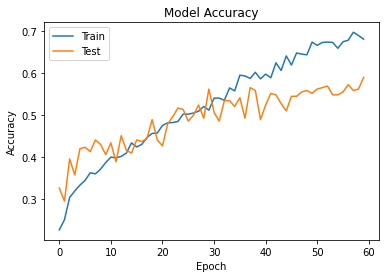

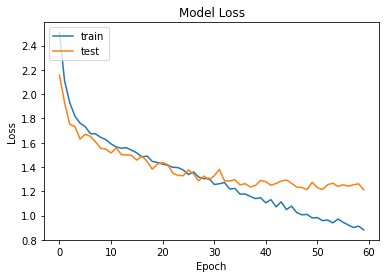

In [67]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [68]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

288/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Loss of the model is -  1.2114784121513367
288/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy of the model is -  59.02777910232544 %


In [69]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)

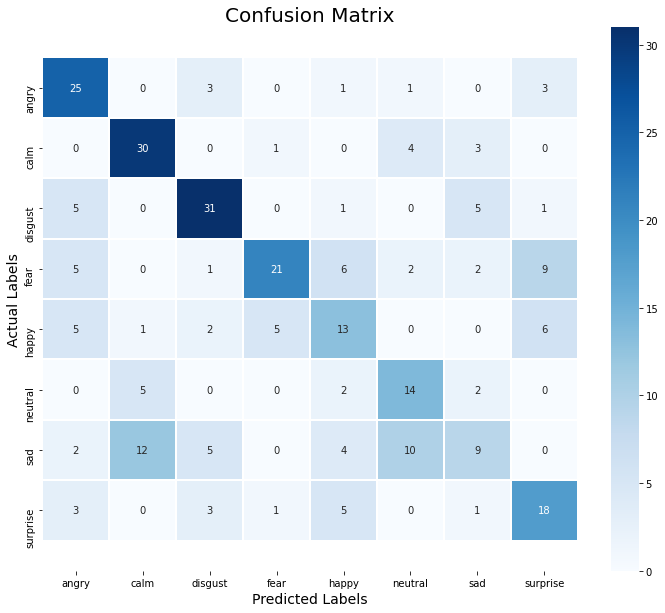

In [63]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()